<a href="https://colab.research.google.com/github/usaeva-a/PET-projects/blob/main/sportsman_error_prediction/skating_error_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Предсказание возможности совершения ошибки фигуристом</center></h1>

<font size="4"><b>Описание исследования</b></font>

Компания GoProtect помогает спортивным школам фигурного катания, тренерам мониторить результаты своих подопечных и планировать дальнейшее развитие спортсменов.

<font size="4"><b>Цель проекта</b></font>

В рамках данного проекта необходимо создать модель, способную предсказывать возможность совершения ошибки спортсменом на соревнованиях и, таким образом, скорректировать подготовку фигуриста.

<font size="4"><b>Задачи исследования</b></font>

Разработать модель машинного обучения для предсказания возможность совершения ошибки.


<font size="4"><b>Исходные данные</b></font>

В наличии 4 csv-файла с данными:
1. `units.csv` - данные по спортсмену (юниту)
2. `tournaments.csv` - данные о турнире
3. `total_scores` - оценки за выступления по категориям и общие за турнир
4. `tournament_scores` - Таблица с оценками поэлементно

Описание столбцов:

**units.csv**
- id: идентификатор юнита
- color: категория
- school_id: идентификатор школы

**tournaments.csv**
- id: идентификатор турнира
- date_start: дата начала
- date_end: дата завершения
- origin_id: место проведения.

**total_scores**
- id: идентификатор выступления, джойнится с tournament_scores.total_score_id
- unit_id: идентификатор юнита, ключ к units.id
- tournament_id: идентификатор турнира, tournaments.id
- components_score: артистизм (мастерство, композиция, хореография)
- base_score: базовая оценка за элементы в выступлении (идеал)
- elements_score: реальная оценка всех выполненных элементов, base_score+goe
- decreasings_score: снижения оценок за ошибки
- total_score: components_score+elements_score+decreasings_score за выступление
- starting_place:
- place: занятое место в категории category_name+segment_name
- segment_name: название сегмента
- info: комментарии и пояснения к оценке
- overall_place: итоговое место в турнире
- overall_total_score: итоговая оценка за весь турнир
- overall_place_str: комментарии, пояснения.

**tournament_scores**
- id: идентификатор оценки за конкретный элемент/комбинацию
- total_score_id: идентикатор выступления, ключ total_scores.id
- title: запись элемента или комбинации элементов с отметками об ошибках
- decrease: за что снижена оценка
- base_score: базовая оценка (идеал, цена данного элемента/комбинации, сложность)
- goe: Grade of Execute, качество исполнения, судейские надбавки/убавки
- avg_score: оценка за элемент/комбинацию (усредненная по судьям)


In [77]:
!pip install phik -q

In [78]:
!pip install catboost -q

In [79]:
!pip install shap -q

In [80]:
# импорт библиотек
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import statistics as st
import warnings
import shap

# загружаем необходимые инструменты
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import phik
from phik.report import plot_correlation_matrix
from phik import phik_matrix

# загружаем классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler
)

# загружаем инструмент для автоподбора гиперпараметров
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные метрики
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.dummy import DummyClassifier

In [81]:
# улучшение чёткости изображения
%config InlineBackend.figure_format = 'retina'

# настройка шрифтов заголовков и подписей для графиков
large = 16; med = 14; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'figure.titleweight': 'bold'}
plt.rcParams.update(params)

# отображение всех строк и столбцов датафрейма
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

In [82]:
# задание константных значений
RANDOM_STATE = 99
TEST_SIZE = 0.3

## Загрузка данных и их первоначальный обзор

Считаем последовательно все 4 таблицы и сохраним их в переменных. Затем просмотрим 10 случайных строчек и основную информацию методом info().

In [83]:
# сохранение данных о спортсмене в переменной units и их предварительный просмотр
units = pd.read_csv('/content/sample_data/units.csv')
units.sample(10)

id  color  school_id
4583   5114  green      288.0
4573    210  green       25.0
1221   2346  green      111.0
1548   3733  green        NaN
2666    936  green       22.0
4406   9997  green      198.0
4093   5038  green      274.0
2227   2096  green      111.0
4578   1870  green      111.0
788   10155   lime        NaN

In [84]:
units.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4596 non-null   int64  
 1   color      4595 non-null   object 
 2   school_id  4007 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 107.8+ KB


In [85]:
# сохранение данных об оценках за турнир
total_scores = pd.read_csv('/content/sample_data/total_scores.csv')
total_scores.sample(10)

id  unit_id  tournament_id  base_score  components_score  \
6740   448570     3075           6847        5.90             10.50   
7054   463416     2235           7117       15.58             22.95   
6164   458027     1866           7110        6.60              0.00   
8186   449793     2052           6859       34.94             42.27   
11473  454564     2803           7106        5.40              9.64   
14432    9623      671             48       25.43             25.27   
3938   446092      805           6676       31.49             29.04   
20164   14461     2345             85       18.55             25.25   
19861    4414      409              9       44.10             44.93   
4854   446693      807           6682       54.29             50.73   

       total_score  elements_score  decreasings_score  starting_place  place  \
6740         16.82            6.32                0.0               5      3   
7054         38.16           15.21                0.0               7     11   
6164         12.10            6.05                0.0              25     23   
8186         79.90           37.63                0.0              12      2   
11473        14.15            5.01               -0.5              14     13   
14432        48.71           24.44                0.0              17     10   
3938         64.95           35.91                0.0              38     10   
20164        42.58           17.33                0.0              11      6   
19861        87.96           44.03                0.0               9      2   
4854        101.28           51.55               -1.0              12      6   

                  segment_name  \
6740   Произвольная программа.   
7054   Произвольная программа.   
6164                    Прыжки   
8186    Произвольная программа   
11473   Произвольная программа   
14432       Короткая программа   
3938        Короткая программа   
20164       Короткая программа   
19861       Короткая программа   
4854    Произвольная программа   

                                                    info  overall_place  \
6740   Мастерство катания@@@1.50@@@3,75@@@3,25@@@3,25...              3   
7054   q Прыжок приземлён в четверть < Недокрученный ...              0   
6164                                     Снижения@@@0.00              0   
8186   < Недокрученный прыжок ! Неясное ребро на толч...              2   
11473  Мастерство катания@@@1.50@@@3,25@@@3,25@@@3,25...             13   
14432  q Прыжок приземлён в четверть x Надбавка за пр...              8   
3938   x Надбавка за прыжки во второй половине програ...              8   
20164  q Прыжок приземлён в четверть < Недокрученный ...              4   
19861  q Прыжок приземлён в четверть x Надбавка за пр...              1   
4854   q Прыжок приземлён в четверть < Недокрученный ...              3   

       overall_total_score overall_place_str  
6740                 16.82                 3  
7054                  0.00               NaN  
6164                  0.00               NQD  
8186                123.58                 2  
11473                14.15                13  
14432               144.30               NaN  
3938                189.89                 8  
20164               114.25               NaN  
19861               280.95               NaN  
4854                163.98                 3

In [86]:
total_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21284 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14  overall_place_str    10814 non-null  object 
dtypes: float64(6), int64(6), object(3)
m

In [87]:
# сохранение данных об оценках в переменной tournament_scores и их предварительный просмотр
tournament_scores = pd.read_csv('/content/sample_data/tournament_scores.csv')
tournament_scores.sample(20)

id  total_score_id      title decrease  base_score   goe  \
83877    95634           29790   3T+COMBO        F        0.00 -2.10   
13614    17143            5249     CCoSp3      NaN        3.00  0.10   
126439  214255          448644         1A      NaN        1.10  0.11   
51597    60151           11186         2F      NaN        1.80  0.06   
77159   225968          450229   2Fq+2Lo<        <        3.16 -0.54   
68960    78865           13764   2F!+2Loq        !        3.50 -0.54   
123560  336018          461294     ChSpl1      NaN        1.50 -0.05   
126522  214338          448656       SSp1      NaN        1.30  0.22   
133149  221835          449662      ChSq1      NaN        3.00  0.67   
113900  187848          445260     CCoSp3      NaN        3.00  0.80   
37441    44286            8636     CCoSp3      NaN        3.00  0.42   
68042    77868           13644      StSq1      NaN        1.80  0.30   
45959    54154            9832      FCSp3      NaN        2.80  0.56   
121519  162008          442770       LSp4      NaN        2.70  0.45   
23736    28301            6645        3S<        F        3.44 -1.72   
109185  182744          444653  3Lz+COMBO      NaN        5.90 -2.95   
27043    31938            7124        3Tq        q        4.20 -1.12   
158006  343079          462243      StSqB      NaN        1.50  0.10   
62053    71330           12753      3T+2T      NaN        5.50  0.56   
41268    48675            9162       LSp4      NaN        2.70  0.81   

        avg_score  
83877        2.52  
13614        3.10  
126439       1.21  
51597        1.86  
77159        2.62  
68960        2.96  
123560       1.45  
126522       1.52  
133149       3.67  
113900       3.80  
37441        3.42  
68042        2.10  
45959        3.36  
121519       3.15  
23736        1.72  
109185       2.95  
27043        3.08  
158006       1.60  
62053        6.06  
41268        3.51

In [88]:
tournament_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              172158 non-null  int64  
 1   total_score_id  172158 non-null  int64  
 2   title           172158 non-null  object 
 3   decrease        41185 non-null   object 
 4   base_score      172158 non-null  float64
 5   goe             172158 non-null  float64
 6   avg_score       172158 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 9.2+ MB


In [89]:
# сохранение данных о турнирах в переменной tournaments и их предварительный просмотр
tournaments = pd.read_csv('/content/sample_data/tournaments.csv',
                          parse_dates=['date_start', 'date_end'])
tournaments.sample(10)

id date_start   date_end  origin_id
49     52 2091-04-28 2091-04-30        2.0
94   5459 2092-01-10 2092-01-12        1.0
28     30 2091-02-10 2091-02-11        2.0
129  7098 2092-03-12 2092-03-14        0.0
56     76 2091-01-23 2091-01-27        1.0
76    351 2091-09-21 2091-09-22        1.0
72     95 2089-09-20 2089-09-23        1.0
29     31 2091-02-14 2091-02-18        2.0
4       5 2090-10-21 2090-10-24        2.0
108  6854 2091-12-06 2091-12-06        0.0

In [90]:
tournaments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          142 non-null    int64         
 1   date_start  142 non-null    datetime64[ns]
 2   date_end    142 non-null    datetime64[ns]
 3   origin_id   142 non-null    float64       
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 4.6 KB


Во всех четырёх датафреймах присутствует столбец под названием `id`, но в каждом из них содержится информация о разных по смыслу значениях. Переименуем эти столбцы перед объединением.

In [91]:
# переименуем столбцы `id` во всех датафреймах и
# `base_score` в датафреймах tournament_scores и tournaments
units = units.rename(columns=
     {'id': 'unit_id'})
total_scores = total_scores.rename(columns=
     {'id': 'total_score_id',
      'base_score': 'base_score_tourn'})
tournament_scores = tournament_scores.rename(columns=
     {'id': 'score_id',
      'base_score': 'base_score_element'})
tournaments = tournaments.rename(columns=
     {'id': 'tournament_id'})

In [92]:
# объединение всех 4 датафреймов в один
combined = tournament_scores.merge(total_scores, on='total_score_id', how='left')
combined = combined.merge(units, on='unit_id', how='left')
combined = combined.merge(tournaments, on='tournament_id', how='left')

In [93]:
# отсортируем сразу весь датасет, чтобы события шли в хронологическом порядке
combined = combined.sort_values(by='date_start')

In [94]:
# проверка размерности исходных и объединённого датафрейма
row_number = []
column_number = []
for df in [units, tournaments, total_scores, tournament_scores, combined]:
  row_number.append(df.shape[0])
  column_number.append(df.shape[1])

shape_check = pd.DataFrame({
    'dataframe_name': ['units', 'tournaments', 'total_scores', 'tournament_scores', 'combined'],
    'rows': row_number,
    'columns': column_number})

shape_check

dataframe_name    rows  columns
0              units    4596        3
1        tournaments     142        4
2       total_scores   21301       15
3  tournament_scores  172158        7
4           combined  172158       26

Объединение получилось правильное: строки/столбцы не потерялись и не дублируются.

In [95]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172158 entries, 108298 to 172157
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   score_id             172158 non-null  int64         
 1   total_score_id       172158 non-null  int64         
 2   title                172158 non-null  object        
 3   decrease             41185 non-null   object        
 4   base_score_element   172158 non-null  float64       
 5   goe                  172158 non-null  float64       
 6   avg_score            172158 non-null  float64       
 7   unit_id              172158 non-null  int64         
 8   tournament_id        172158 non-null  int64         
 9   base_score_tourn     172158 non-null  float64       
 10  components_score     172158 non-null  float64       
 11  total_score          172158 non-null  float64       
 12  elements_score       172158 non-null  float64       
 13  decreasings_sc

In [96]:
# разделим данные на числовые (float и int) и строковые (object)
num_cols = combined.select_dtypes('number').columns.tolist()
cat_cols= combined.select_dtypes('object').columns.tolist()

# разделим числовые признаки на дискретные и непрерывные
disc_cols = []
cont_cols = []
for col in num_cols:
  if combined[col].nunique() <= 20:
    disc_cols.append(col)
  else:
    cont_cols.append(col)

print(f'Числовых дискретных признаков - {len(disc_cols)}')
print(f'Числовых непрерывных признаков - {len(cont_cols)}')
print(f'Строковых признаков - {len(cat_cols)}')

Числовых дискретных признаков - 2
Числовых непрерывных признаков - 16
Строковых признаков - 6


In [97]:
print(f"Имеются данные за период с {combined['date_start'].min()} до {combined['date_end'].max()}")
print(f"Имеются данные по {combined['tournament_id'].nunique()} турнирам и {combined['unit_id'].nunique()} спортсмену.")

# извлечение месяца из даты начала соревнования
combined['month'] = combined['date_start'].dt.month

Имеются данные за период с 2089-09-20 00:00:00 до 2092-05-03 00:00:00
Имеются данные по 142 турнирам и 3393 спортсмену.


При передаче данных годы были смещены, но день и месяц оригинальные. В целом нам для анализа и моделирования достаточно информации, что у нас данные о соревнованиях за 3 года. Также для моделирования используем признак `month` - месяц начала соревнования.

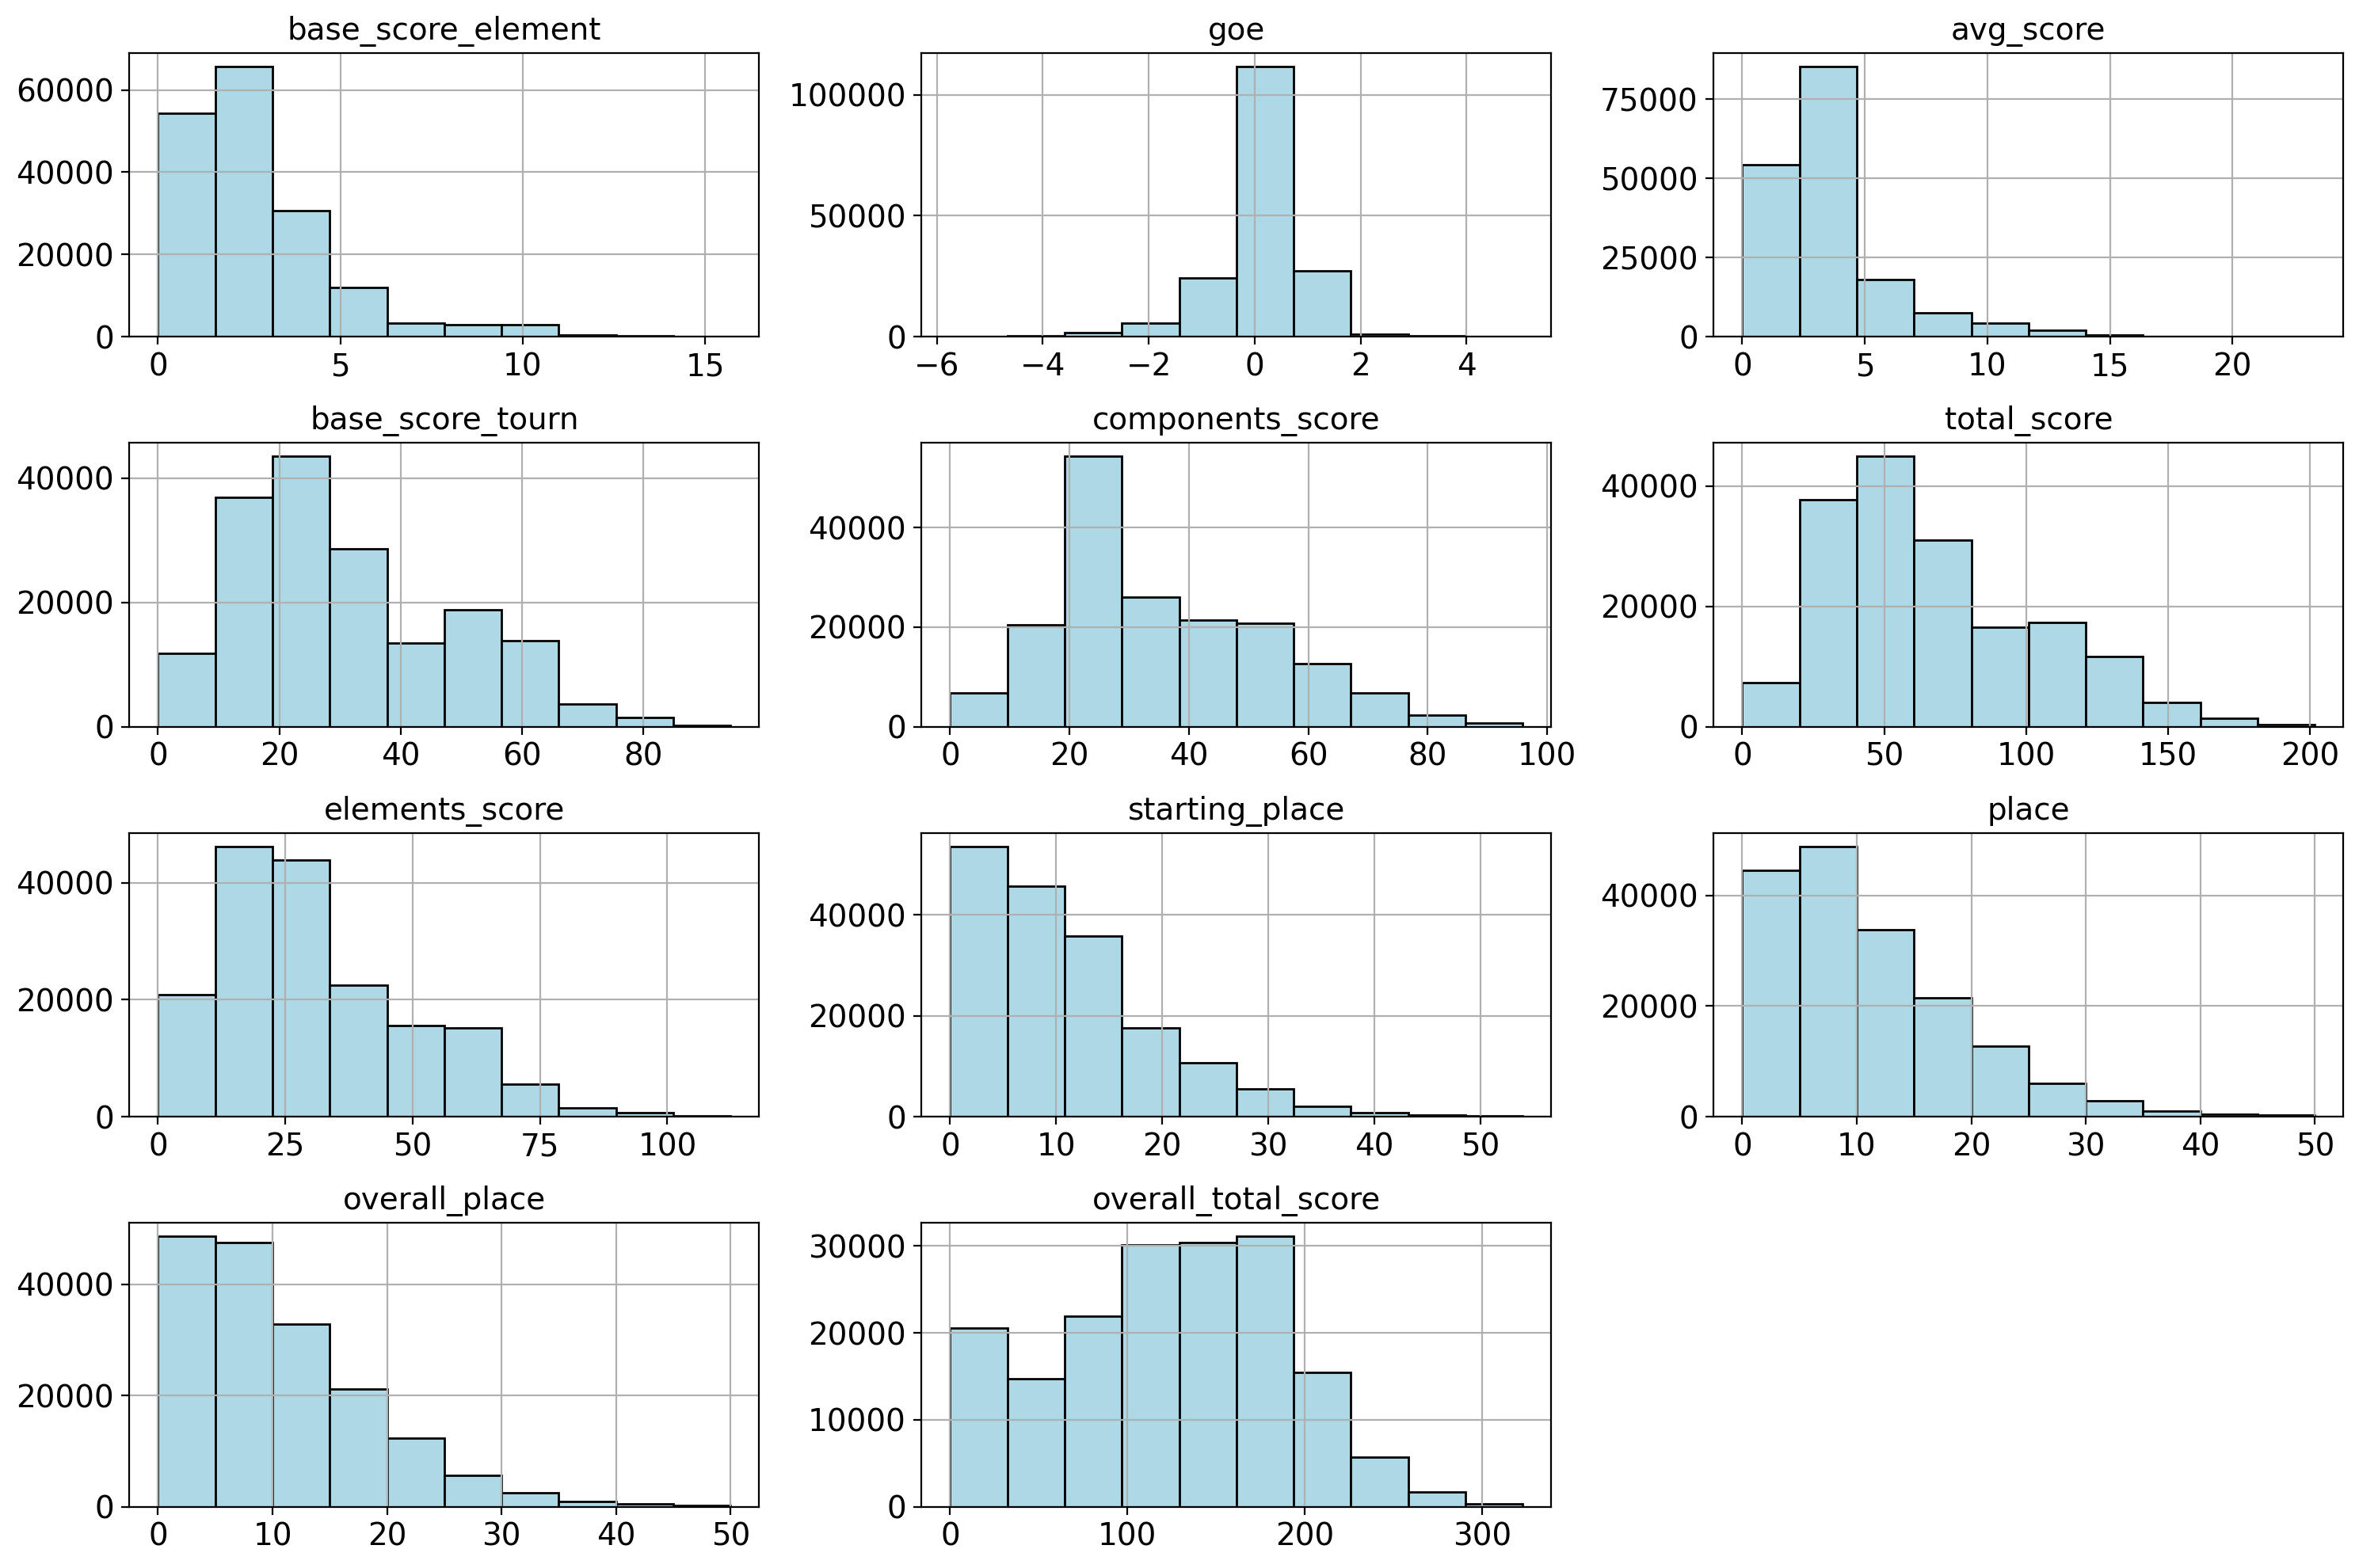

In [98]:
# предварительный обзор гистограмм распределения
# для количественных непрерывных признаков
combined[['base_score_element',
          'goe',
          'avg_score',
          'base_score_tourn',
          'components_score',
          'total_score',
          'elements_score',
          'starting_place',
          'place',
          'overall_place',
          'overall_total_score']].hist(figsize=(15, 10),
                                       color='lightblue', ec='black')
plt.tight_layout()
plt.show()

На первый взгляд все количественные непрерывные признаки имеют распределение отличное от нормальной. Только для признака `goe` значения выглядят симметрично распределенными относительно нуля.

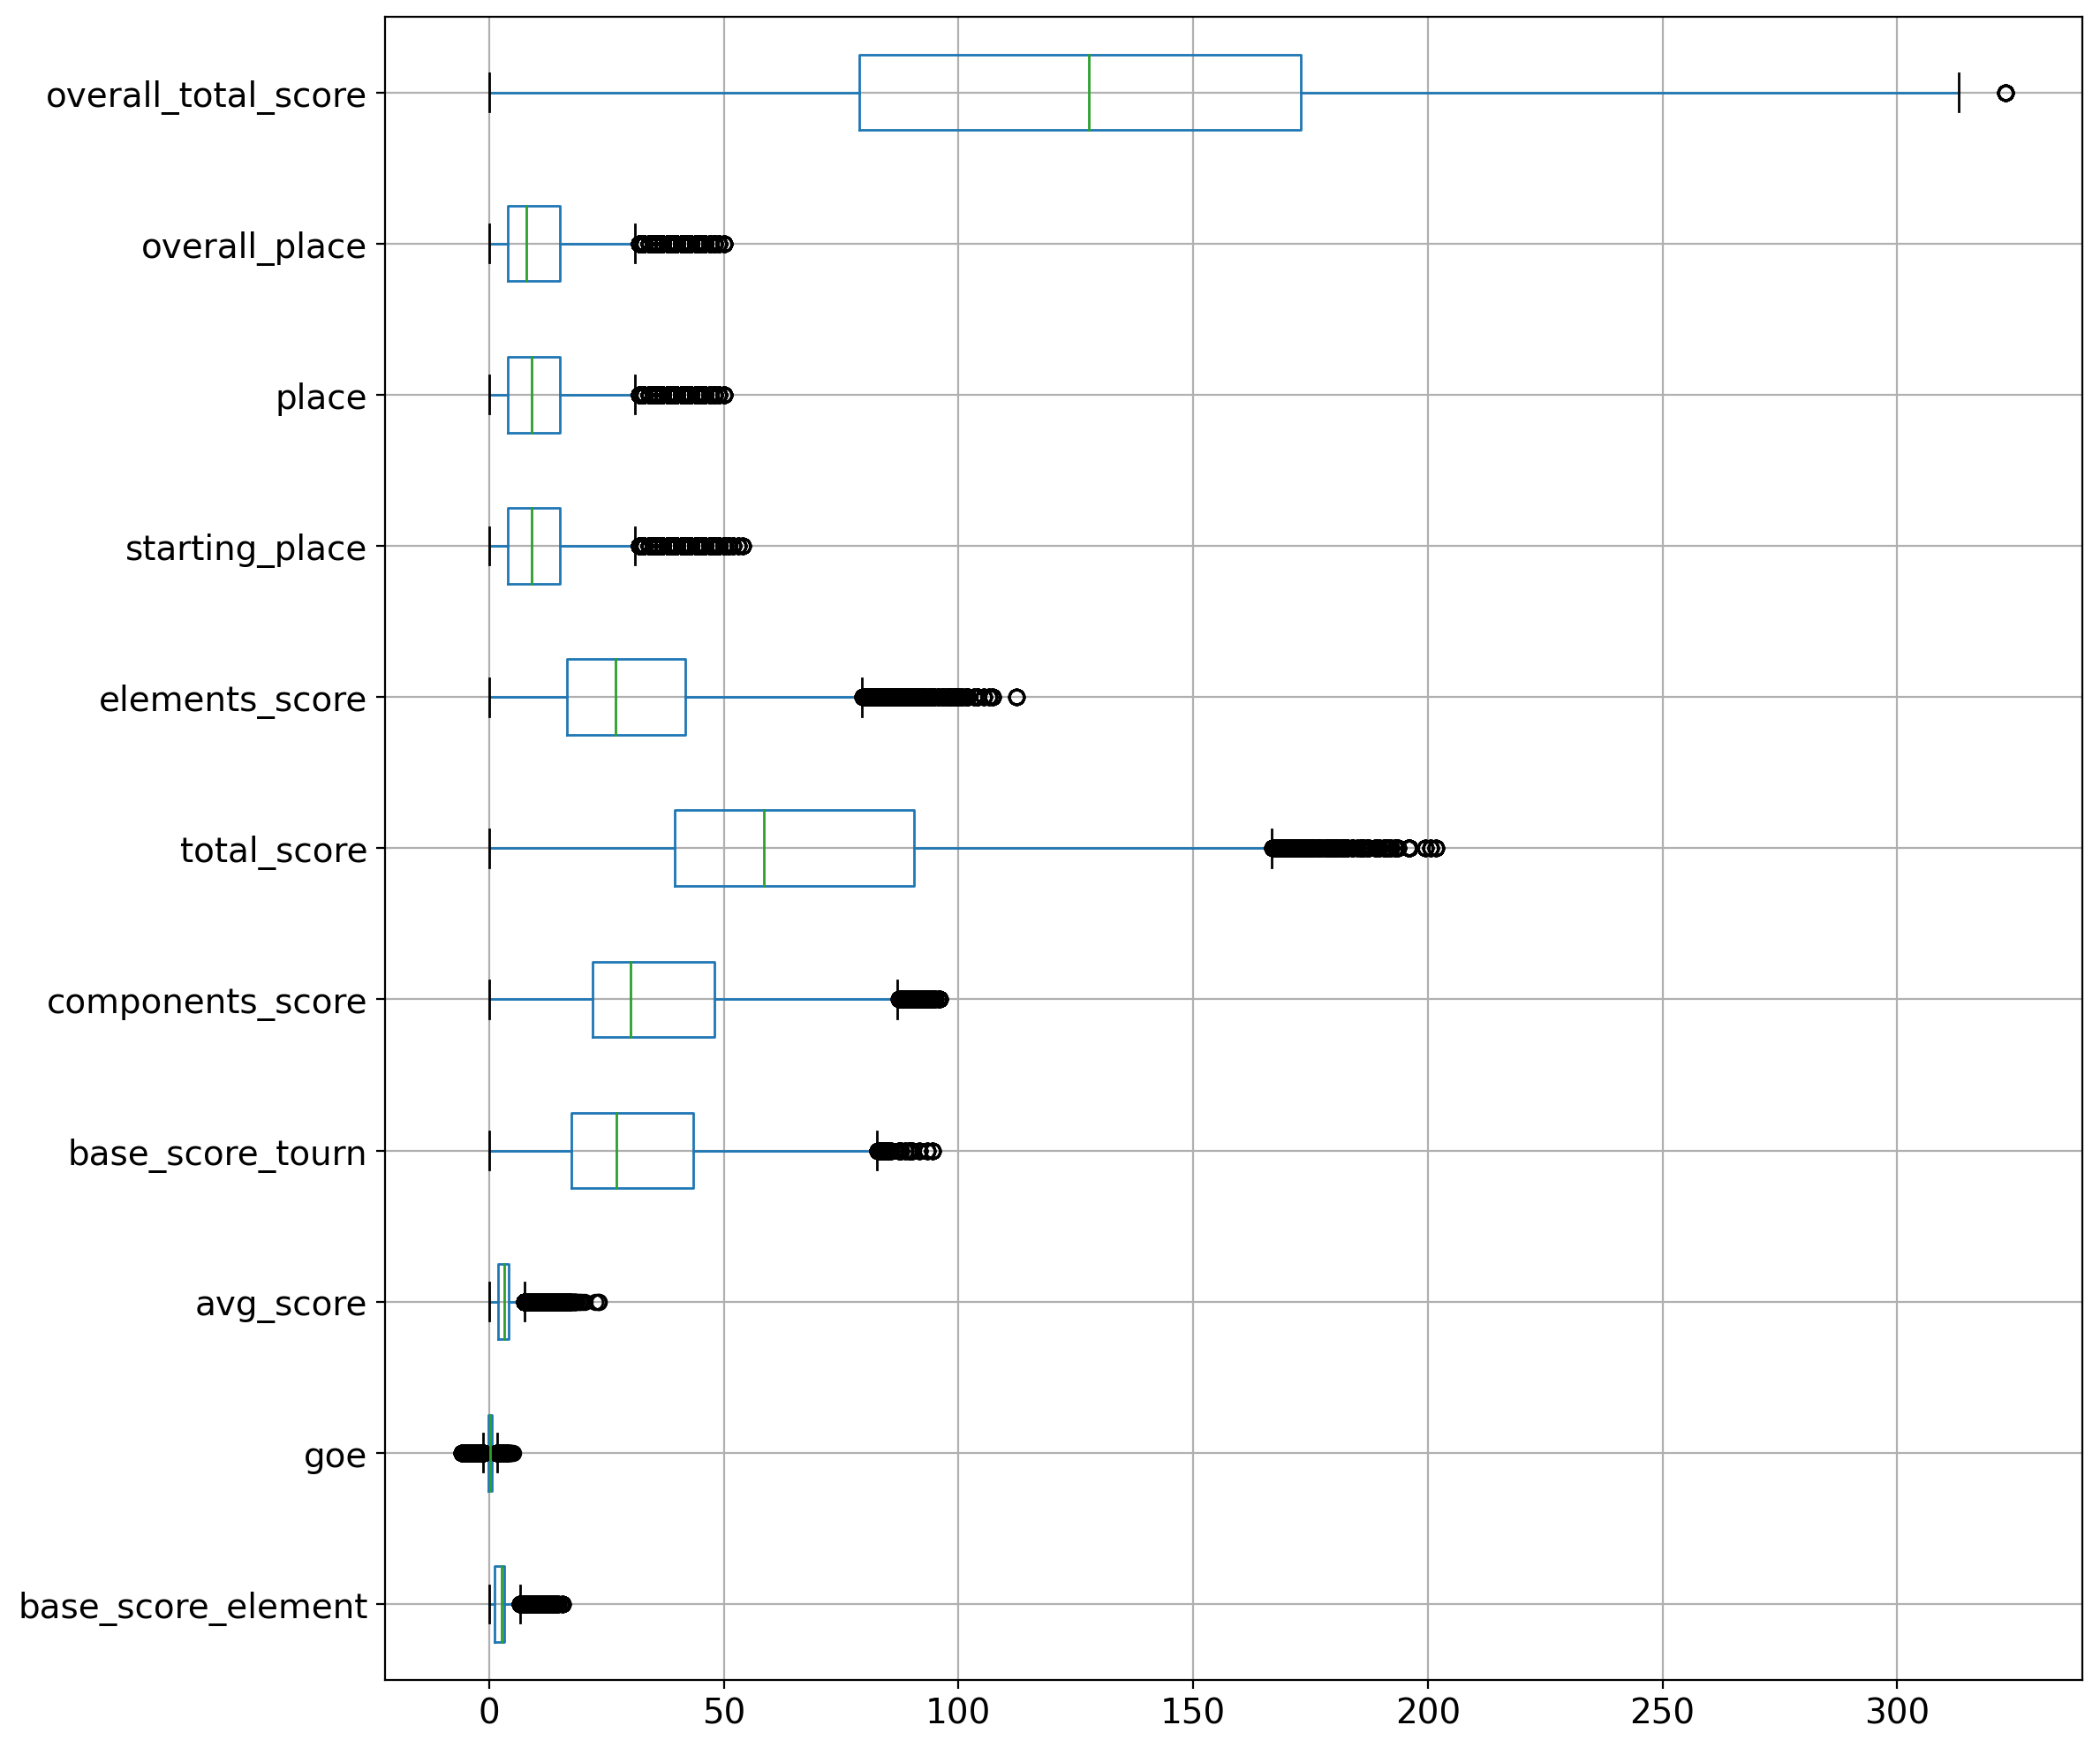

In [99]:
# предварительный обзор диаграмм размаха
combined[['base_score_element',
          'goe',
          'avg_score',
          'base_score_tourn',
          'components_score',
          'total_score',
          'elements_score',
          'starting_place',
          'place',
          'overall_place',
          'overall_total_score']].boxplot(vert=False, figsize=(12, 10))
plt.tight_layout()
plt.show()

Данные имеют разный масштаб. В целом серьёзных аномальных значений не видно. Есть значения, выходящие за пределы нормального размаха, но они не являются выбросами, а соответсвуют профессиональным фигуристам с максимальными оценками (группа признаков, описывающих оценки) и соревнованиям с большим количеством участников (признаки `place`, `starting_place`)

In [100]:
# просмотр количественных данных
temp = combined.copy()

temp.describe()

score_id  total_score_id  base_score_element            goe  \
count  172158.000000   172158.000000       172158.000000  172158.000000   
mean   148848.485444   243100.514156            2.574300       0.131771   
min         1.000000        1.000000            0.000000      -5.750000   
25%     50613.250000     9385.000000            1.100000      -0.120000   
50%    158772.500000   442337.000000            2.600000       0.210000   
75%    223563.750000   449883.750000            3.300000       0.600000   
max    353806.000000   463639.000000           15.700000       5.060000   
std    107651.944104   219065.848493            2.151716       0.797761   

           avg_score        unit_id  tournament_id  base_score_tourn  \
count  172158.000000  172158.000000  172158.000000     172158.000000   
mean        3.567541    2206.930465    3034.109539         31.018123   
min         0.000000       1.000000       1.000000          0.000000   
25%         1.980000     409.000000      47.000000         17.520000   
50%         3.250000    1059.000000     177.000000         27.080000   
75%         4.200000    2146.000000    6851.000000         43.590000   
max        23.360000   35024.000000    7117.000000         94.420000   
std         2.424646    4180.223001    3256.770873         17.339338   

       components_score    total_score  elements_score  decreasings_score  \
count     172158.000000  172158.000000   172158.000000       172158.00000   
mean          35.013908      67.139976       30.940115           -0.25846   
min            0.000000       0.000000        0.000000           -7.00000   
25%           22.130000      39.530000       16.590000            0.00000   
50%           30.190000      58.630000       26.880000            0.00000   
75%           48.060000      90.450000       41.790000            0.00000   
max           95.900000     201.650000      112.420000            0.00000   
std           18.047844      35.697764       18.996570            0.61117   

       starting_place          place  overall_place  overall_total_score  \
count   172158.000000  172158.000000  172158.000000        172115.000000   
mean        10.821182      10.503677      10.100524           123.497441   
min          0.000000       0.000000       0.000000             0.000000   
25%          4.000000       4.000000       4.000000            78.920000   
50%          9.000000       9.000000       8.000000           127.710000   
75%         15.000000      15.000000      15.000000           172.840000   
max         54.000000      50.000000      50.000000           323.050000   
std          8.180611       7.912984       7.876928            65.019023   

           school_id                     date_start  \
count  164913.000000                         172158   
mean      460.822840  2091-06-28 22:00:08.280766464   
min         1.000000            2089-09-20 00:00:00   
25%        62.000000            2091-01-23 00:00:00   
50%       111.000000            2091-04-28 00:00:00   
75%       198.000000            2092-02-05 00:00:00   
max     99999.000000            2092-04-29 00:00:00   
std      5705.737439                            NaN   

                            date_end      origin_id          month  
count                         172158  172158.000000  172158.000000  
mean   2091-07-01 17:25:30.561461760       1.229382       5.621336  
min              2089-09-23 00:00:00       0.000000       1.000000  
25%              2091-01-27 00:00:00       1.000000       2.000000  
50%              2091-04-30 00:00:00       1.000000       4.000000  
75%              2092-02-08 00:00:00       2.000000      10.000000  
max              2092-05-03 00:00:00       2.000000      12.000000  
std                              NaN       0.791530       3.959627

<font size="4"><b>Выводы по первоначальному обзору данных объединенного датафрейма</b></font>

- Четыре исходных таблицы были объединены в одну.
- В объединённом датафрейме 172158 строчек и 26 столбцов. Из них числовых дискретных - 2, числовых непрерывных - 16, строковых - 6, дата-время - 2.
- Названия столбцов написаны "змеиным" регистром, поэтому переименовывать не надо.
- Проверить неявные и явные дубликаты.
- Есть пропуски в 6 столбцах.
- Типы данных преобразовывать не нужно.
- Аномальных значений на первый взгляд нет.


## Знакомство с данными

При предварительном обзоре было выявлено, что некоторые столбцы имеют большое количество нулевых значений. Посмотрим на их количество и насколько это имеет смысл.

In [101]:
len(combined.query('base_score_element == 0 and avg_score == 0'))

4031

In [102]:
combined.query('base_score_element == 0 and avg_score == 0').sample(5)

score_id  total_score_id       title decrease  base_score_element  \
43289      50695            9392           A      NaN                 0.0   
77100     225936          450224        CSSp      NaN                 0.0   
107937    200751          446903   2A*+COMBO        *                 0.0   
88725     167068          443360  3S<<*+2Lo*       <<                 0.0   
162192    307340          458268       ChSpl      NaN                 0.0   

        goe  avg_score  unit_id  tournament_id  base_score_tourn  \
43289   0.0        0.0      741             47             53.51   
77100   0.0        0.0     1752           6864              8.06   
107937  0.0        0.0     9899           6699             13.50   
88725   0.0        0.0      180           5879             11.20   
162192  0.0        0.0     4191           7110              5.68   

        components_score  total_score  elements_score  decreasings_score  \
43289              64.94       118.23           54.29                0.0   
77100              21.07        29.39            8.82               -0.5   
107937              0.00        28.08           14.04                0.0   
88725               0.00        23.76           11.88                0.0   
162192              7.51        10.97            5.46               -2.0   

        starting_place  place             segment_name  \
43289                8     19   Произвольная программа   
77100                1      1  Произвольная программа.   
107937              10     15                 Элементы   
88725                9     17                 Элементы   
162192              19     39  Произвольная программа.   

                                                     info  overall_place  \
43289   q Прыжок приземлён в четверть ! Неясное ребро ...             22   
77100   q Прыжок приземлён в четверть < Недокрученный ...              1   
107937                                    Снижения@@@0.00             20   
88725                                     Снижения@@@0.00             18   
162192  Мастерство катания@@@1.50@@@2,75@@@2,75@@@2,75...             39   

        overall_total_score overall_place_str  color  school_id date_start  \
43289                185.23               NaN   lime       82.0 2091-04-11   
77100                 29.39                 1   lime       38.0 2092-02-10   
107937               138.12                20   lime       65.0 2092-02-23   
88725                118.95                18  green       38.0 2092-01-29   
162192                10.97                39  green      286.0 2092-04-09   

         date_end  origin_id  month  
43289  2091-04-13        2.0      4  
77100  2092-02-15        0.0      2  
107937 2092-02-27        2.0      2  
88725  2092-02-02        1.0      1  
162192 2092-04-12        1.0      4

В данных присутствуют элементы, у которых base_score и avg_score равны нулю, т.к. прыжок не засчитан/было падение/был недопустимый элемент/недокрут >180 градусов (значки *, F, <<). Тут всё выглядит верно.

Кроме того, в данных присутствуют строчки, в которых base_score_element равен нулю, а avg_score и goe не равен. В этом случае, это похоже на ошибку в данных, т.к. похоже, что элемент был выполнен и оценен судьями.

In [103]:
len(combined.query('base_score_element == 0 and avg_score != 0'))

29760

In [104]:
combined.query('base_score_element == 0 and avg_score != 0').sample(5)

score_id  total_score_id     title decrease  base_score_element   goe  \
3620        3947            3718    3Lz+3T      NaN                 0.0 -0.94   
139040    353609          463617       3Fq        q                 0.0 -1.77   
81494     163555          442948     3T+2T      NaN                 0.0  0.00   
17957      22321            5863  3Lz<+3T<        <                 0.0 -1.58   
49745      58204           10285        3S      NaN                 0.0  0.86   

        avg_score  unit_id  tournament_id  base_score_tourn  components_score  \
3620        10.17     5060              3             37.01             37.49   
139040       4.06     2861           7117             49.79             41.39   
81494        6.05     1615           4793             53.54             50.94   
17957        7.31      675             20             26.27             29.58   
49745        5.59      678             52             52.56             50.52   

        total_score  elements_score  decreasings_score  starting_place  place  \
3620          78.69           41.20                0.0              28      8   
139040        81.93           43.54               -3.0              25      2   
81494        104.66           53.72                0.0              13      9   
17957         57.25           27.67                0.0              29      9   
49745         98.28           50.76                0.0              20     17   

                  segment_name  \
3620        Короткая программа   
139040  Произвольная программа   
81494   Произвольная программа   
17957       Кoроткая программа   
49745   Произвольная программа   

                                                     info  overall_place  \
3620    x Надбавка за прыжки во второй половине програ...              9   
139040  q Прыжок приземлён в четверть < Недокрученный ...              0   
81494   q Прыжок приземлён в четверть < Недокрученный ...             10   
17957   q Прыжок приземлён в четверть < Недокрученный ...              9   
49745   q Прыжок приземлён в четверть x Надбавка за пр...             16   

        overall_total_score overall_place_str  color  school_id date_start  \
3620                 220.73               NaN   lime       62.0 2090-10-05   
139040                 0.00               NaN  green       62.0 2092-04-29   
81494                154.77                10  green      203.0 2091-12-09   
17957                160.39               NaN  green      135.0 2091-01-17   
49745                153.57               NaN  green    99999.0 2091-04-28   

         date_end  origin_id  month  
3620   2090-10-08        2.0     10  
139040 2092-05-03        0.0      4  
81494  2091-12-11        2.0     12  
17957  2091-01-20        2.0      1  
49745  2091-04-30        2.0      4

Можно частично восстановить данные в столбце `base_score_element` с помощью таблицы с базовыми оценками для всех возможных элементов с ошибками и без, кроме каскадов.

In [105]:
# загрузка таблицы с базовыми оценками
base_score_correct = pd.read_excel('/content/sample_data/SSPScomm_2475.xlsx',
                                   sheet_name='Table 1')
base_score_correct.head(5)

title    -5    -4    -3    -2    -1  base_score     1     2     3     4  \
0    1T -0.20 -0.16 -0.12 -0.08 -0.04         0.4  0.04  0.08  0.12  0.16   
1    1S -0.20 -0.16 -0.12 -0.08 -0.04         0.4  0.04  0.08  0.12  0.16   
2   1Lo -0.25 -0.20 -0.15 -0.10 -0.05         0.5  0.05  0.10  0.15  0.20   
3   1Eu -0.25 -0.20 -0.15 -0.10 -0.05         0.5  0.05  0.10  0.15  0.20   
4    1F -0.25 -0.20 -0.15 -0.10 -0.05         0.5  0.05  0.10  0.15  0.20   

      5  
0  0.20  
1  0.20  
2  0.25  
3  0.25  
4  0.25

In [106]:
# оставим только 2 столбца этой таблицы
base_score_corr = base_score_correct[['title', 'base_score']]

# добавим эти столбцы к датафрейму combined
combined = combined.merge(base_score_corr, on='title', how='left')

In [107]:
# восстановление данных в `base_score_element` данными из файла
combined['bs_corrected'] = np.where(
    combined['base_score_element'] == 0, combined['base_score'], combined['base_score_element'])

# заполним оставшиеся значения нулем
combined['bs_corrected'] = combined['bs_corrected'].fillna(0)

In [108]:
combined[['title', 'base_score_element', 'avg_score', 'base_score', 'bs_corrected']].sample(10)

title  base_score_element  avg_score  base_score  bs_corrected
56912       CSSp4                 3.0       3.36         3.0           3.0
94784          2F                 1.8       1.44         1.8           1.8
29244        3S<<                 1.3       0.78         1.3           1.3
57263          2A                 3.3       4.10         3.3           3.3
121527      FSSp2                 2.3       2.68         2.3           2.3
43202         2F!                 1.8       1.62         1.8           1.8
83741          2A                 3.3       3.96         3.3           3.3
101600  3T+2A+SЕQ                 0.0       8.81         NaN           0.0
20009       StSq2                 2.6       2.77         2.6           2.6
39175       StSq1                 1.8       1.98         1.8           1.8

Из полученной таблицы видно, что система оценок в исходном файле и файле с базовыми оценками совпадает. Кроме того, файл с базовыми оценками позволяет частично восстановить данные в столбце `base_score_element`, где были нули. Нулевыми остаются только значения, соответствующие каскадам прыжков.

In [109]:
# удалим столбцы 'base_score_element' и 'base_score'
combined = combined.drop(['base_score_element', 'base_score'], axis=1)

В данных присутствуют строчки с `elements_score` (оценка за все выполненные элементы равная base_score+goe) равным нулю, но при этом base_score_element,	goe, avg_score не равны нулю.

In [110]:
len(combined.query('elements_score == 0'))

3744

In [111]:
combined.query('elements_score == 0').head(5)

score_id  total_score_id    title decrease   goe  avg_score  unit_id  \
1     182209          444591       2A      NaN -0.11       3.19     9709   
2     182208          444591       3F      NaN  1.06       6.36     9709   
16    182210          444591   CCoSp4        B  1.40       4.90     9709   
18    182211          444591  3Lz+3Tq        q -0.59      10.52     9709   
19    182213          444591    StSq3      NaN  0.99       4.29     9709   

    tournament_id  base_score_tourn  components_score  total_score  \
1              95             32.31             35.66        74.67   
2              95             32.31             35.66        74.67   
16             95             32.31             35.66        74.67   
18             95             32.31             35.66        74.67   
19             95             32.31             35.66        74.67   

    elements_score  decreasings_score  starting_place  place  \
1              0.0                0.0              11      4   
2              0.0                0.0              11      4   
16             0.0                0.0              11      4   
18             0.0                0.0              11      4   
19             0.0                0.0              11      4   

          segment_name                                               info  \
1   Короткая программа  x Надбавка за прыжки во второй половине програ...   
2   Короткая программа  x Надбавка за прыжки во второй половине програ...   
16  Короткая программа  x Надбавка за прыжки во второй половине програ...   
18  Короткая программа  x Надбавка за прыжки во второй половине програ...   
19  Короткая программа  x Надбавка за прыжки во второй половине програ...   

    overall_place  overall_total_score overall_place_str color  school_id  \
1               5               199.78                 5  lime       62.0   
2               5               199.78                 5  lime       62.0   
16              5               199.78                 5  lime       62.0   
18              5               199.78                 5  lime       62.0   
19              5               199.78                 5  lime       62.0   

   date_start   date_end  origin_id  month  bs_corrected  
1  2089-09-20 2089-09-23        1.0      9           3.3  
2  2089-09-20 2089-09-23        1.0      9           5.3  
16 2089-09-20 2089-09-23        1.0      9           3.5  
18 2089-09-20 2089-09-23        1.0      9           0.0  
19 2089-09-20 2089-09-23        1.0      9           3.3

<font size="4"><b>Выводы по этапу знакомства с данными</b></font>

- Были выявлены неточности в данных, возможно связанные со сканированием бумажных исходников, переносом из различных источников:
- Есть строчки, в которых базовая оценка за элемент (base_score_element) равна нулю, но при этом есть средняя оценка (avg_score) и goe. Это было расценено как ошибка и частично восстановлено с помощью файла с базовыми оценками.
- Есть строки, в которых `elements_score` равна нулю, но при этом base_score_element,	goe, avg_score не равны нулю. Это тоже выглядит ошибочным.

## Предобработка данных

Этап предобработки данных необходим для подготовки данных для их более корректого анализа.
Он включает в себя следующие пункты, которые проводятся при необходимости:
- переименование названий столбцов;
- обработка пропусков;
- преобразование типов данных;
- обработка аномалий;
- обработка дубликатов.


### Обработка пропусков

In [112]:
temp = combined.copy()
display(
    pd.DataFrame(
                round(
                      (temp.isna().mean()*100), 2), columns=['NaNs, %']
                )
    .sort_values(by='NaNs, %')
            .style.format('{:.2f}').background_gradient('coolwarm')
        )

Пропуски есть в 6 столбцах: `segment_name`, `overall_total_score`, `info`, `school_id`, `overall_place_str`, `decrease`.

Посмотрим на столбец `overall_place_str` совместно с `overall_place`, чтобы понять насколько важный признак.

In [113]:
combined[['overall_place_str', 'overall_place']].sample(20)

overall_place_str  overall_place
25278                NaN              2
88027                NaN              2
170611               NaN              0
13472                 10             10
131071                 1              1
133121                16             16
34398                NaN             18
93213                 12             12
10044                NaN             18
144379                 2              2
133844                 9              9
164396                45             45
96428                  3              3
75532                NaN             18
116011                24             24
60433                NaN              8
46002                NaN             21
18600                NaN              1
90326                  1              1
139105                11             11

In [114]:
combined['overall_place_str'].unique()

array(['1', '5', 'WD', '23', '7', '15', '9', '18', '21', '22', '10', '14',
       '13', '3', '2', '6', '4', '16', '11', '25', '17', '20', '24', '12',
       '8', '19', '26', '28', '27', '29', '31', '30', nan, 'FNR', '32',
       '33', 'NQD', '34', '36', '35', '44', '45', '41', '38', '39', '47',
       '48', '37', '46', '43', '42', '40', '50', '49'], dtype=object)

В столбце 'overall_place_str' дублируется информация с 'overall_place' с дополнительными пояснениями в случае если занятое место равно `0`: FNR - Final not reached, NQD, WD - withdrawn. Можно было бы заполнить пропуски исходя из 'overall_place', но ценность признака 'overall_place_str' небольшая, поэтому лучше удалить его.



В столбце `decrease` записана причина, по которой была снижена оценка, но более полная информация содержится в столбце `info`, поэтому удалим столбец `decrease`.

Таким образом, **удалим строки** в столбцах `segment_name`, `overall_total_score`, `info`, `school_id` и **удалим столбцы** `overall_place_str`, `decrease`.

In [115]:
# удаление строк с пропусками меньше 5%
combined = combined.dropna(subset=['segment_name',
                                   'overall_total_score',
                                   'info',
                                   'school_id'])

# удаление столбцов с пропусками больше 50%
combined.drop(['overall_place_str', 'decrease'], axis=1, inplace=True)

# проверка удаления пропусков
combined.isna().sum()

score_id               0
total_score_id         0
title                  0
goe                    0
avg_score              0
unit_id                0
tournament_id          0
base_score_tourn       0
components_score       0
total_score            0
elements_score         0
decreasings_score      0
starting_place         0
place                  0
segment_name           0
info                   0
overall_place          0
overall_total_score    0
color                  0
school_id              0
date_start             0
date_end               0
origin_id              0
month                  0
bs_corrected           0
dtype: int64

### Обработка дубликатов

In [116]:
# разделим данные на числовые (float и int) и строковые (object)
num_cols = combined.select_dtypes('number').columns.tolist()
cat_cols= combined.select_dtypes('object').columns.tolist()

# разделим числовые признаки на дискретные и непрерывные
disc_cols = []
cont_cols = []
for col in num_cols:
  if combined[col].nunique() <= 20:
    disc_cols.append(col)
  else:
    cont_cols.append(col)

print(f'Числовых дискретных признаков - {len(disc_cols)}')
print(f'Числовых непрерывных признаков - {len(cont_cols)}')
print(f'Строковых признаков - {len(cat_cols)}')

Числовых дискретных признаков - 3
Числовых непрерывных признаков - 16
Строковых признаков - 4


In [117]:
# проверим нет ли неявных дубликатов, посмотрим на уникальные значения
for col in cat_cols + disc_cols:
    print('-'* 25)
    print(col, combined[col].sort_values().unique())
    print(f'Всего уникальных значений {combined[col].nunique()}')

-------------------------
title ['1A' '1A*' '1A*+1Eu+2S' ... 'T' 'USpB' 'USpB*']
Всего уникальных значений 3343
-------------------------
segment_name ['Kopoткaя пpoгpaммa' 'Интерпретация' 'Интерпретация.'
 'Кopoткaя пpoгpaммa' 'Кoроткая программа' 'Коpоткая программа'
 'Короткая программа' 'Пpoизвoльнaя пpoгpaммa' 'Пpoизвольнaя программа'
 'Пpoизвольная программа' 'Прoизвольная прoграмма'
 'Произвольнaя программа' 'Произвольная программа'
 'Произвольная программа.' 'Прыжки' 'Элeмeнты' 'Элементы']
Всего уникальных значений 17
-------------------------
info ['! Неясное ребро на толчке F/Lz'
 '! Неясное ребро на толчке F/Lz F Падение в элементе'
 "! Неясное ребро на толчке F/Lz F Падение в элементе nS Нет базовой позиции 'волчок'"
 ... 'Снижения@@@Нарушение времени:@@@-1.00@@@-1.00'
 'Снижения@@@Падения:@@@0.00'
 'Снижения@@@Хореогр. ограничение:@@@-1.00@@@-1.00']
Всего уникальных значений 1158
-------------------------
color ['green' 'lime']
Всего уникальных значений 2
-----------------

В `segment_name` присутствуют неявные дубликаты, по-видимому связанные с наличием латинских букв в словах. Преобразуем все имеющиеся варианты к едиообразной форме, 'Короткую программу' заменим на 'КП', а 'Произвольную программу' на 'ПП'.

In [118]:
# создание вложенных списков с неверным написанием
wrong = [['Короткая программа', 'Кoроткая программа',
       'Кopoткaя пpoгpaммa', 'Коpоткая программа', 'Kopoткaя пpoгpaммa'],
        ['Произвольная программа', 'Произвольная программа.',
         'Произвольнaя программа',
       'Пpoизвoльнaя пpoгpaммa', 'Пpoизвольная программа',
       'Пpoизвольнaя программа', 'Прoизвольная прoграмма'],
        ['Элементы', 'Элeмeнты'], ['Интерпретация', 'Интерпретация.']]

# список значений для замены
new = ['КП','ПП', 'Элементы', 'Интерпретация']

for w, n in zip(wrong, new):
  combined['segment_name'] = combined['segment_name'].replace(w, n)

# проверка успешной замены неявных дубликатов
combined['segment_name'].unique()

array(['КП', 'ПП', 'Элементы', 'Прыжки', 'Интерпретация'], dtype=object)

### Парсинг столбца `title` на отдельные

Создадим из столбца `title` отдельные столбцы `jump`, `spin`, `step`, `cascade`, `errors` для дальнейшего анализа и моделирования.

In [119]:
# создадим паттерны для каждого нового признака
pattern_jump = r'(\b[1-4](A|T|S|Lo|F|Lz|Eu))'
pattern_step = r'((StSq|ChSq)\d?)'
pattern_spin = r'([a-zA-Z]+(Sp|sp)l?B?\d?)'
#pattern_cascade = r'(([1-4])(A|T|S|Lo|F|Lz|Eu)(?:([^S](q|<{1,2}|e|!|COMBO|REP|\*|V)?))\+([1-4])(A|T|S|Lo|F|Lz|Eu)(?:([^S](q|<{1,2}|e|!|COMBO|REP|\*|V)?))\+?(([1-4])(A|T|S|Lo|F|Lz|Eu))?(?:([^S](q|<{1,2}|e|!|COMBO|REP|\*|V)?))\+?(\w)*)' #good
pattern_cascade = r'(\w{1,4}(<{1,2}|!)?\+\w{1,4}(<{1,2}|!)?\+?(\w{1,4}(<{1,2}|!)?)?\+?(\w)*)'
pattern_error = r'[^Sq](q|<{1,2}|e|!|COMBO|REP|\*|V)'
pattern_bonus = r'(x)\s'

def find_pattern(string, pattern):
    """
    функция осуществляет поиск шаблона "pattern" в строке "string",
    используя правила регулярных выражений(RegExp).
    Если шаблон найден - возвращает значение, иначе - возвращает None

    входные данные: string - текстовая строка для поиска
    pattern - шаблон регулярного выражения
    """
    if re.search(pattern, string):
        return re.search(pattern, string).group(1)

unit_data = pd.DataFrame(columns=['unit_id'])
unit_data[['unit_id', 'title', 'info']] = combined[['unit_id', 'title', 'info']]
unit_data['jump'] = unit_data['title'].apply(lambda x: find_pattern(x, pattern_jump))
unit_data['step'] = unit_data['title'].apply(lambda x: find_pattern(x, pattern_step))
unit_data['spin'] = unit_data['title'].apply(lambda x: find_pattern(x, pattern_spin))
unit_data['cascade'] = unit_data['title'].apply(lambda x: find_pattern(x, pattern_cascade))
unit_data['error_from_title'] = unit_data['title'].apply(lambda x: find_pattern(x, pattern_error))
unit_data['error_from_info'] = unit_data['info'].apply(lambda x: find_pattern(x, pattern_error))
unit_data['bonus'] = unit_data['info'].apply(lambda x: find_pattern(x, pattern_bonus))

unit_data.sample(5)

unit_id   title                                               info  \
40631       389      2F  x Надбавка за прыжки во второй половине програ...   
98124      9914      1A  x Надбавка за прыжки во второй половине програ...   
139990      359    LSp4  x Надбавка за прыжки во второй половине програ...   
156516     4600  CCoSp2  < Недокрученный прыжок << Пониженный прыжок ! ...   
63969       183     2Lo  < Недокрученный прыжок << Пониженный прыжок ! ...   

        jump  step    spin cascade error_from_title error_from_info bonus  
40631     2F  None    None    None             None            None     x  
98124     1A  None    None    None             None            None     x  
139990  None  None    LSp4    None             None            None     x  
156516  None  None  CCoSp2    None             None              <<  None  
63969    2Lo  None    None    None             None              <<  None

Результат получился достаточно хорошим. Необходимо подчистить столбец `jump` в него попали значения из каскадов прыжков. Также создадим столбец `clean_title`, куда сохраним названия всех элементов, но без ошибок.
Также добавим категориальный признак `error_bin` со значениями 1 и 0 - была ошибка/чистое исполнение соответственно.

In [120]:
# удаление прыжков попавших в столбец jump из каскада
unit_data.loc[unit_data['cascade'].notnull(), 'jump'] = None

# в случае отсутствия бонусов заполнить значением 'no'
unit_data['bonus'] = unit_data['bonus'].fillna('no')

# создание столбца clean_title с названиями всех элементов
unit_data['clean_title'] = unit_data[['jump','step','spin','cascade']] \
    .fillna('') \
        .agg(''.join , axis=1)

# создание столбца error с ошибками исполнения
unit_data['errors'] = unit_data[['error_from_title','error_from_info']] \
    .fillna('') \
        .agg('.'.join , axis=1)

# создание категориального признака error_bin была/не была ошибка
# 1 - была ошибка, 0 - выполнено чисто
unit_data['error_bin'] = unit_data['errors'].apply(lambda x: 0 if x == '.' else 1)

In [121]:
unit_data.sample(5)

unit_id           title  \
139829      130            3Lz<   
157898     1027             3Lo   
133386     4639           ChSq1   
7297       1799           StSq2   
142839      250  2Lo+2Tq+1A+SЕQ   

                                                     info  jump   step  spin  \
139829  < Недокрученный прыжок << Пониженный прыжок x ...   3Lz   None  None   
157898  < Недокрученный прыжок e Явно неправильное реб...   3Lo   None  None   
133386  < Недокрученный прыжок e Явно неправильное реб...  None  ChSq1  None   
7297    < Недокрученный прыжок << Пониженный прыжок x ...  None  StSq2  None   
142839  q Прыжок приземлён в четверть x Надбавка за пр...  None   None  None   

               cascade error_from_title error_from_info bonus     clean_title  \
139829            None                <              <<     x             3Lz   
157898            None             None               e     x             3Lo   
133386            None             None               e     x           ChSq1   
7297              None             None              <<     x           StSq2   
142839  2Lo+2Tq+1A+SЕQ                q            None     x  2Lo+2Tq+1A+SЕQ   

       errors  error_bin  
139829   <.<<          1  
157898     .e          1  
133386     .e          1  
7297      .<<          1  
142839     q.          1

In [122]:
to_model = combined.copy()
to_model = to_model.merge(unit_data, on=['unit_id', 'title', 'info'],
                          how='left')

In [123]:
# проверим наличие дубликатов
to_model.duplicated().sum()

82306

In [124]:
# удалениe явных дубликатов
to_model.drop_duplicates(inplace=True)

# проверка удаления явных дубликатов
to_model.duplicated().sum()

0

## Исследовательский анализ данных

In [125]:
def build_hist_num_feature(feature, b, feature_name):
  """
  функция, которая выводит описательную статистику для количественного признака,
  строит гистограмму распределения и
  диаграмму размаха

  входные данные:
    feature - название столбца с количественным признаком,
    b - количество бинов для гистограммы,
    feature_name - название признака
  """
  print(f'Статистика для {feature_name}\n\n {to_model[feature].describe()}')

  fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

  ax1.set_title('Гистограмма распределения')
  ax1.set_ylabel('Частота')
  ax1.grid(True)
  to_model[feature].plot(kind='hist', bins=b, ax=ax1,
                           color='lightblue', ec='black')

  to_model[feature].plot(kind='box', ax=ax2, vert=False)
  ax2.set_xlabel(feature_name)
  ax2.set_title('Разброс значений признака')
  plt.suptitle(feature_name)
  plt.tight_layout()
  plt.show()

Статистика для GOE

 count    161342.000000
mean          0.133665
std           0.807333
min          -5.750000
25%          -0.130000
50%           0.210000
75%           0.600000
max           5.060000
Name: goe, dtype: float64


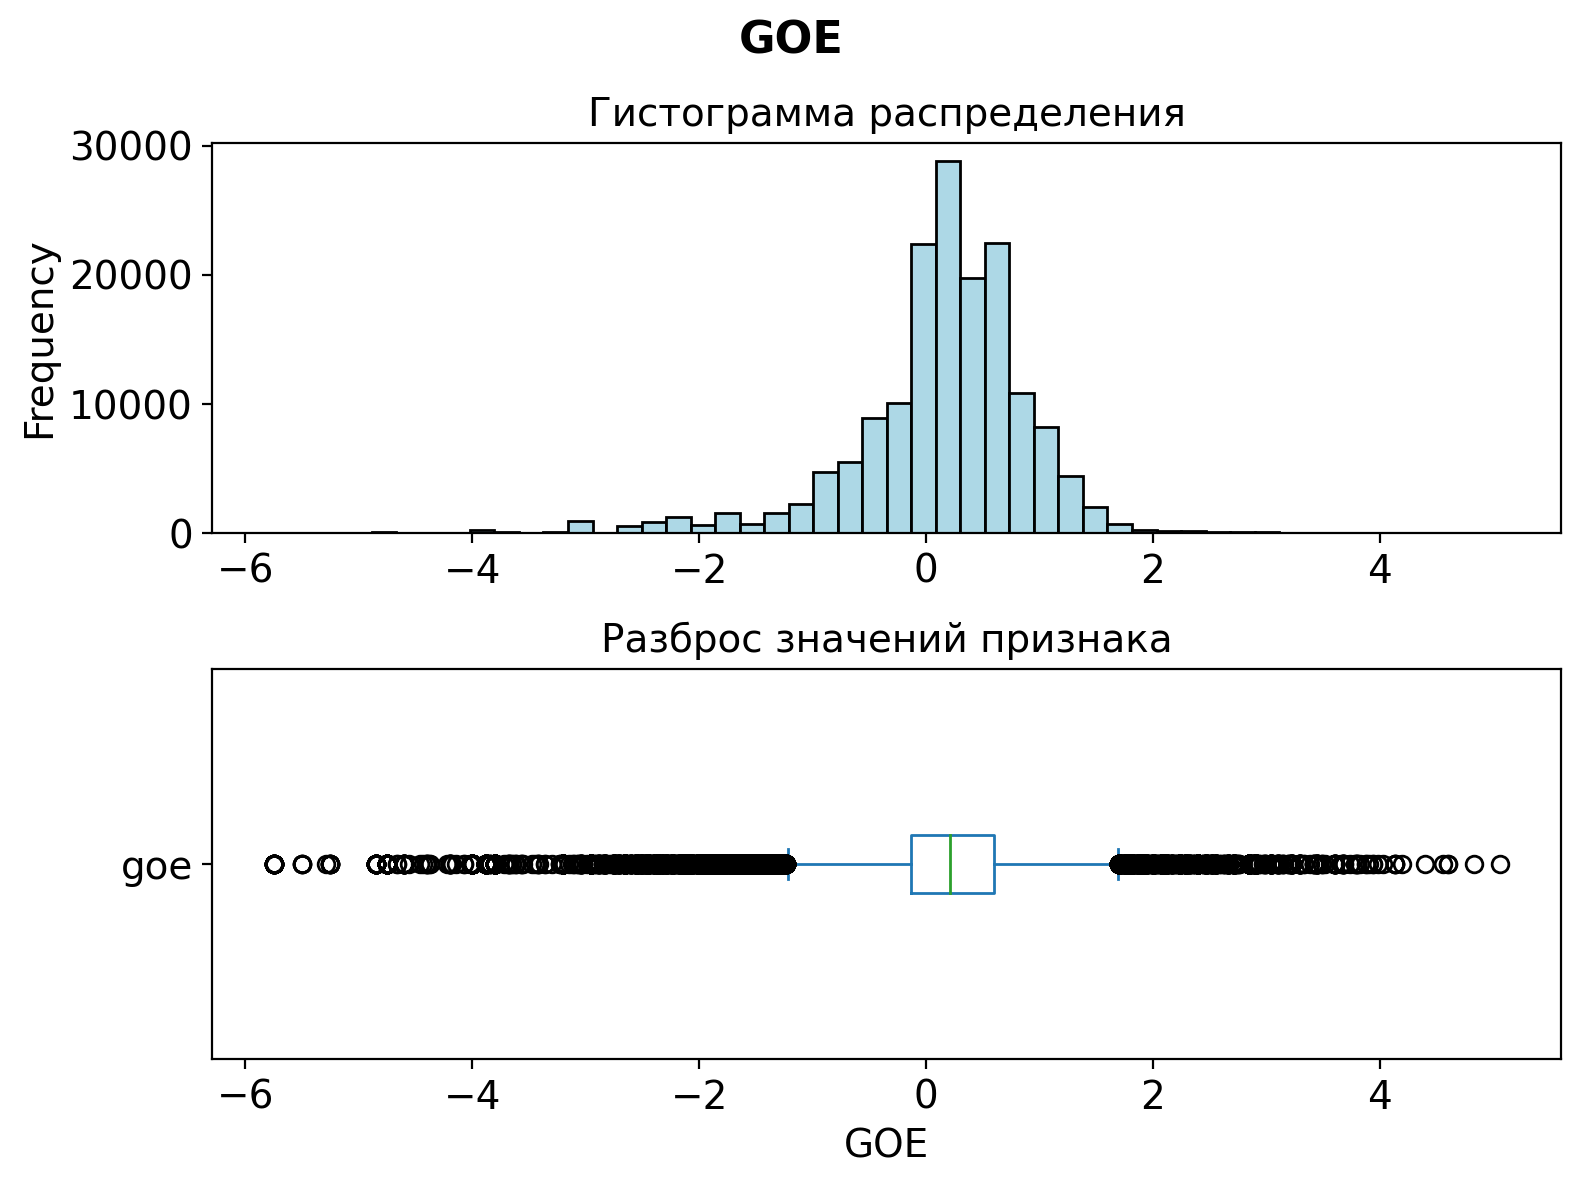

In [126]:
build_hist_num_feature('goe', 50, 'GOE')

Статистика для Усреднённая оценка за элемент/комбинацию

 count    161342.000000
mean          3.608806
std           2.443363
min           0.000000
25%           2.020000
50%           3.300000
75%           4.200000
max          23.360000
Name: avg_score, dtype: float64


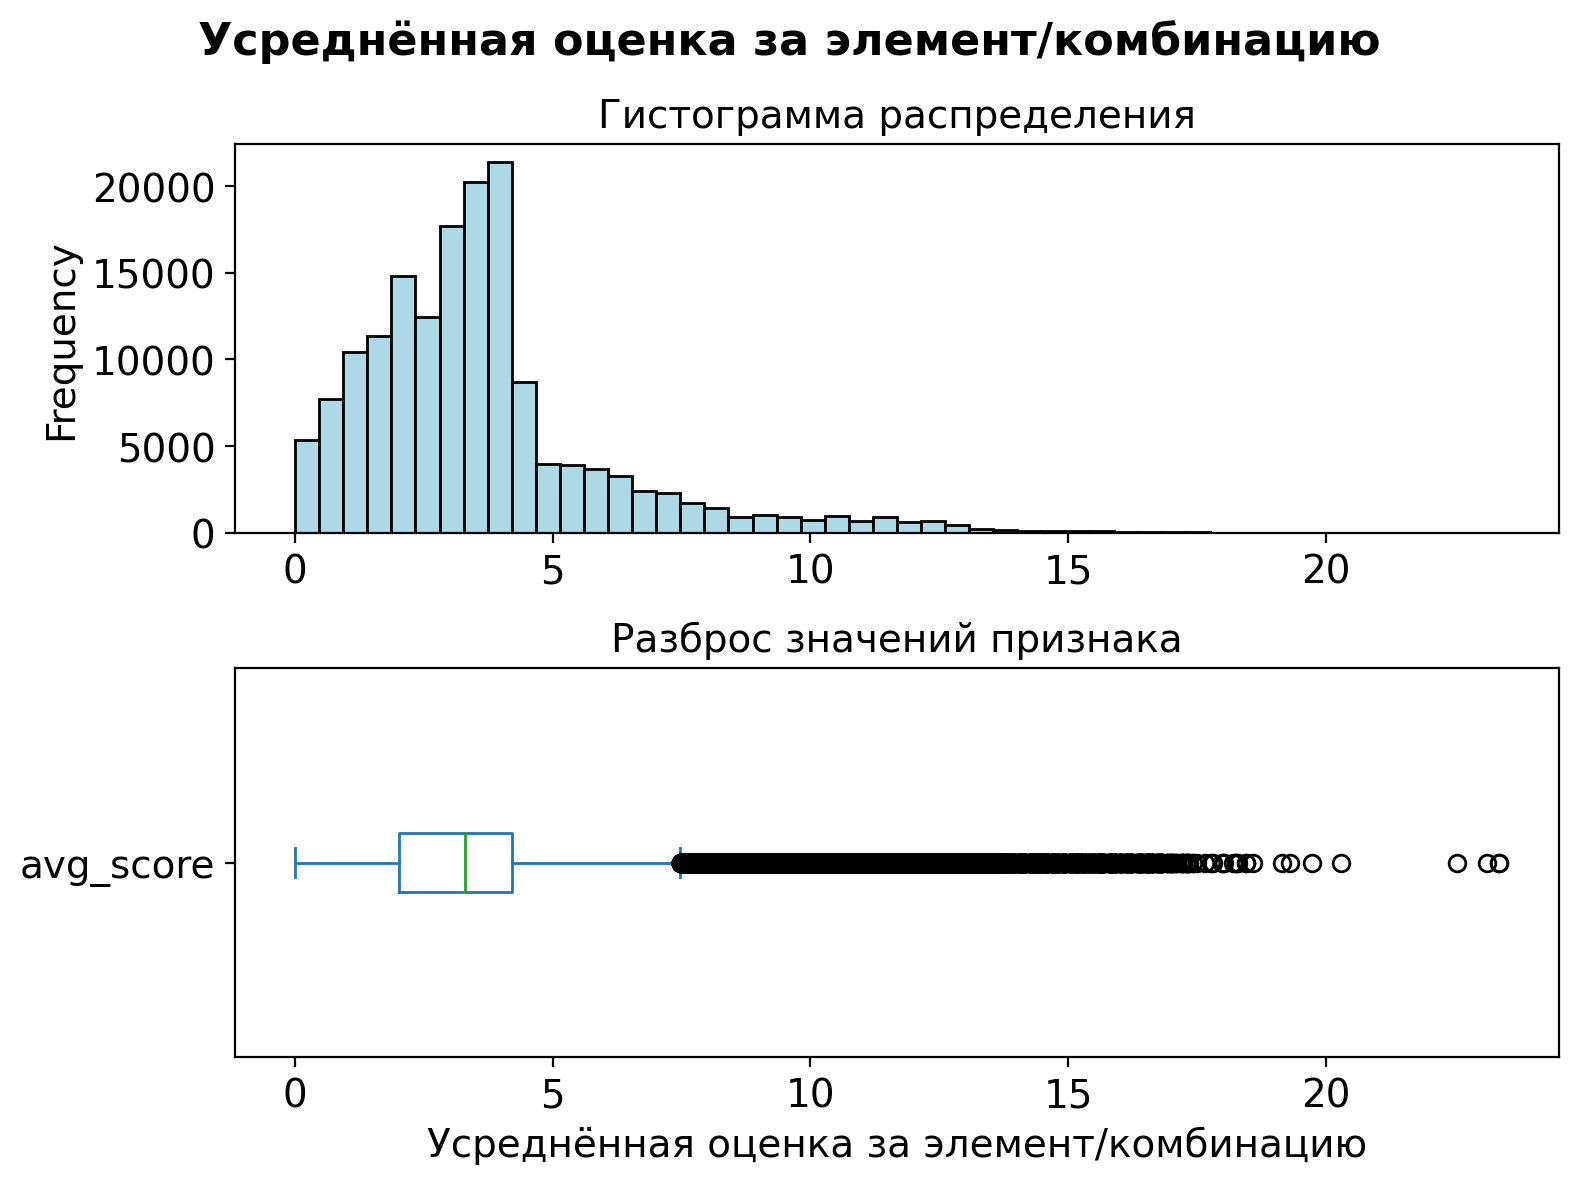

In [127]:
build_hist_num_feature('avg_score', 50, 'Усреднённая оценка за элемент/комбинацию')

Статистика для Оценка за артистизм

 count    161342.000000
mean         35.462864
std          18.190212
min           0.000000
25%          22.290000
50%          30.820000
75%          48.860000
max          95.900000
Name: components_score, dtype: float64


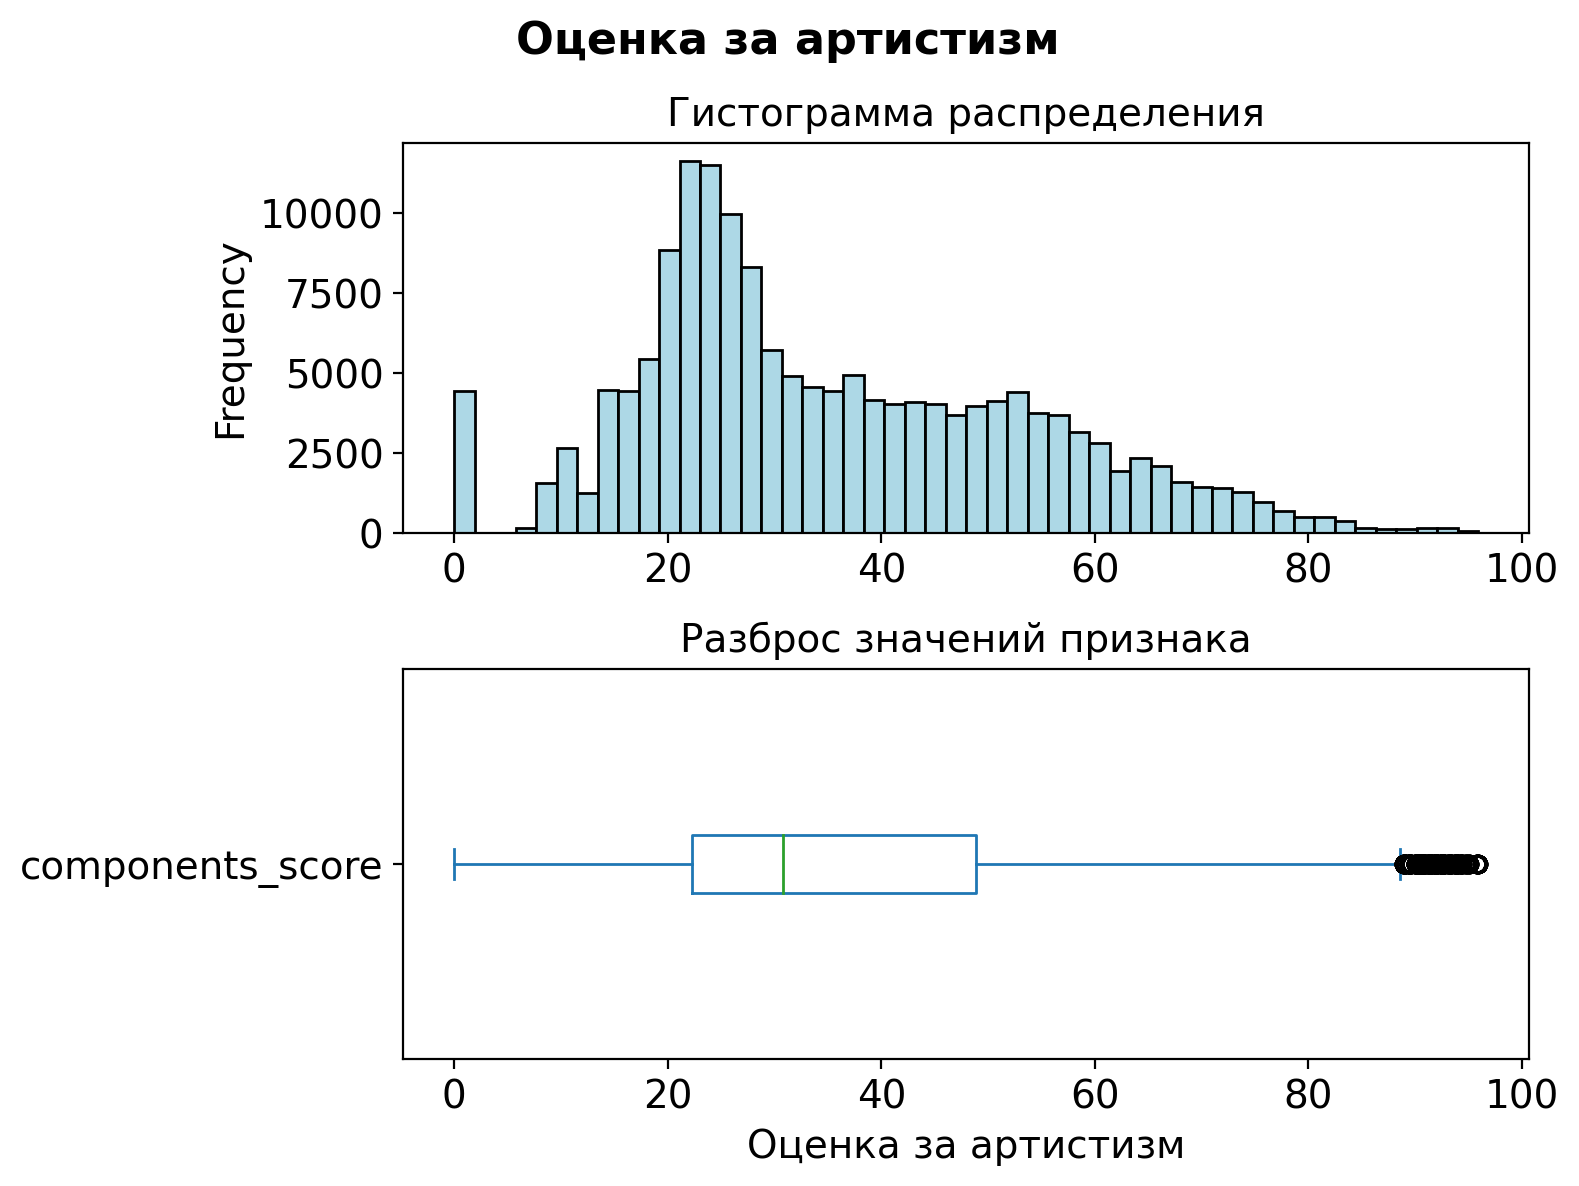

In [128]:
build_hist_num_feature('components_score', 50, 'Оценка за артистизм')

Статистика для Оценка за выступление

 count    161342.000000
mean         68.112654
std          35.977639
min           1.800000
25%          39.960000
50%          59.520000
75%          92.650000
max         201.650000
Name: total_score, dtype: float64


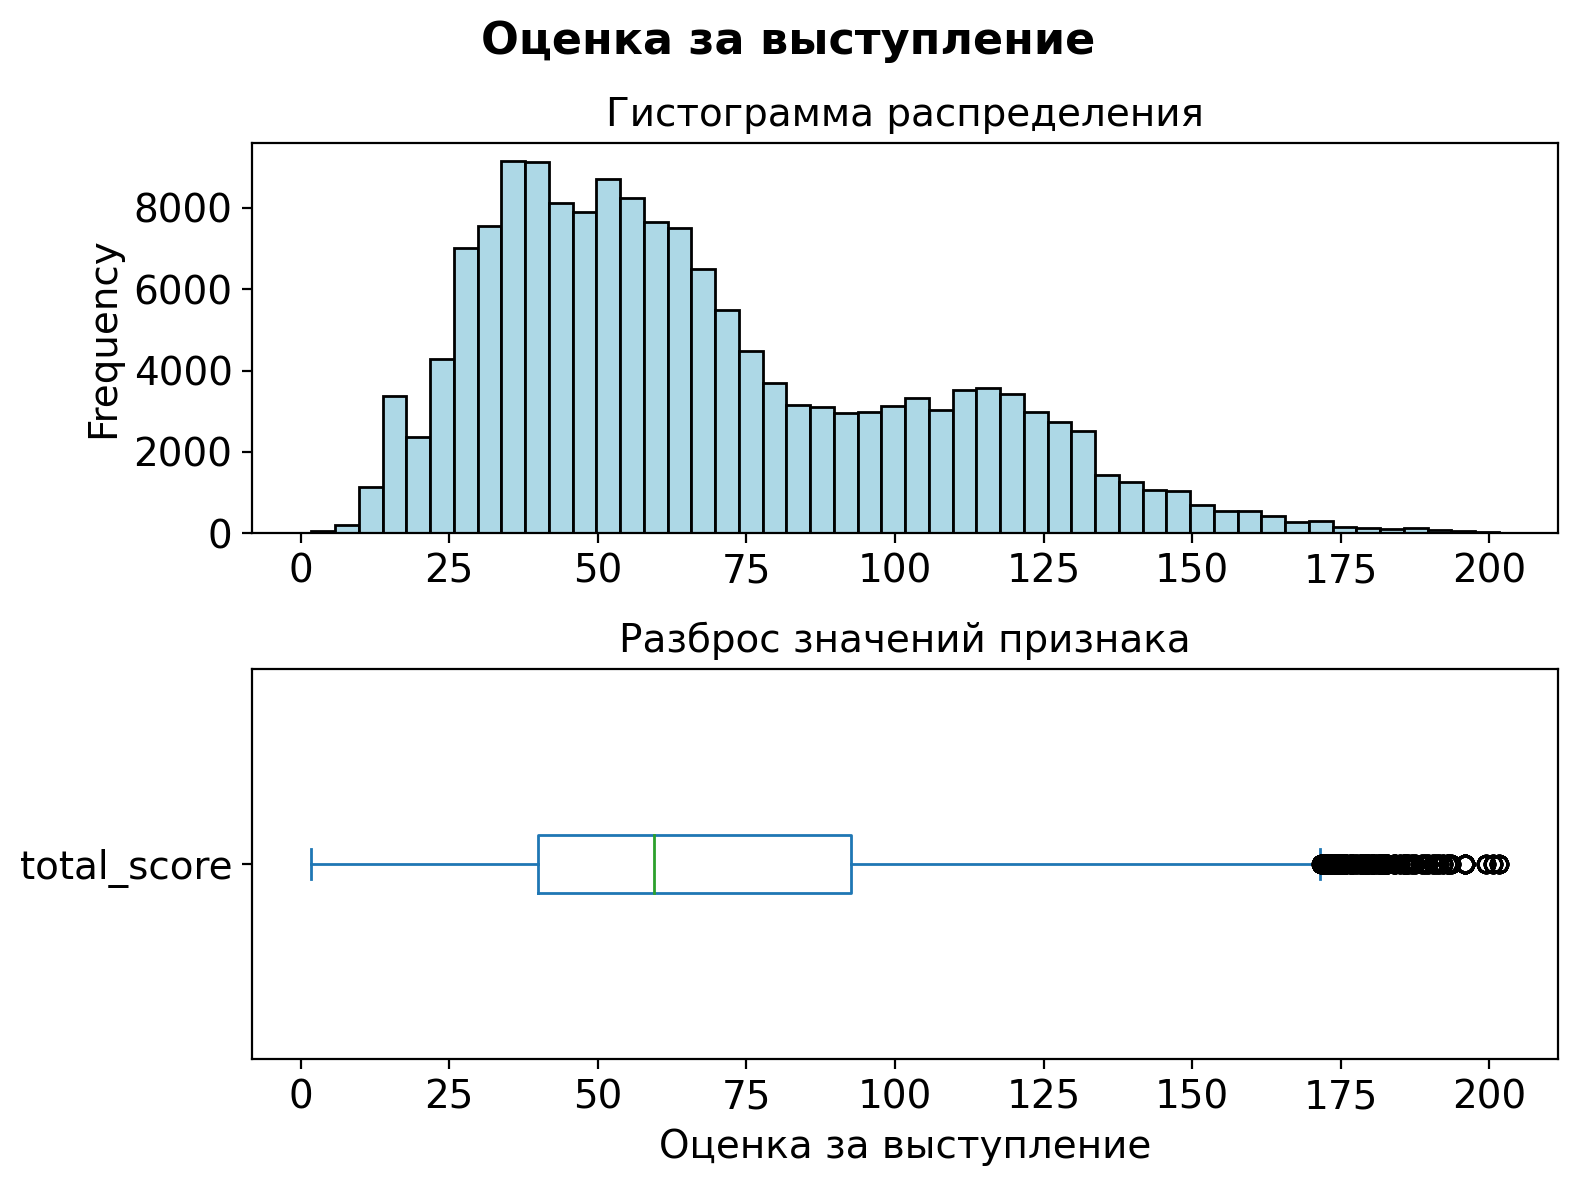

In [129]:
build_hist_num_feature('total_score', 50, 'Оценка за выступление')

На гистограмме выделяется 2 пика. Возможно это связано с влиянием другого признака, например, `segment_name`.

Статистика для Общая оценка за турнир

 count    161342.000000
mean        125.342792
std          64.880131
min           0.000000
25%          80.757500
50%         130.070000
75%         174.180000
max         323.050000
Name: overall_total_score, dtype: float64


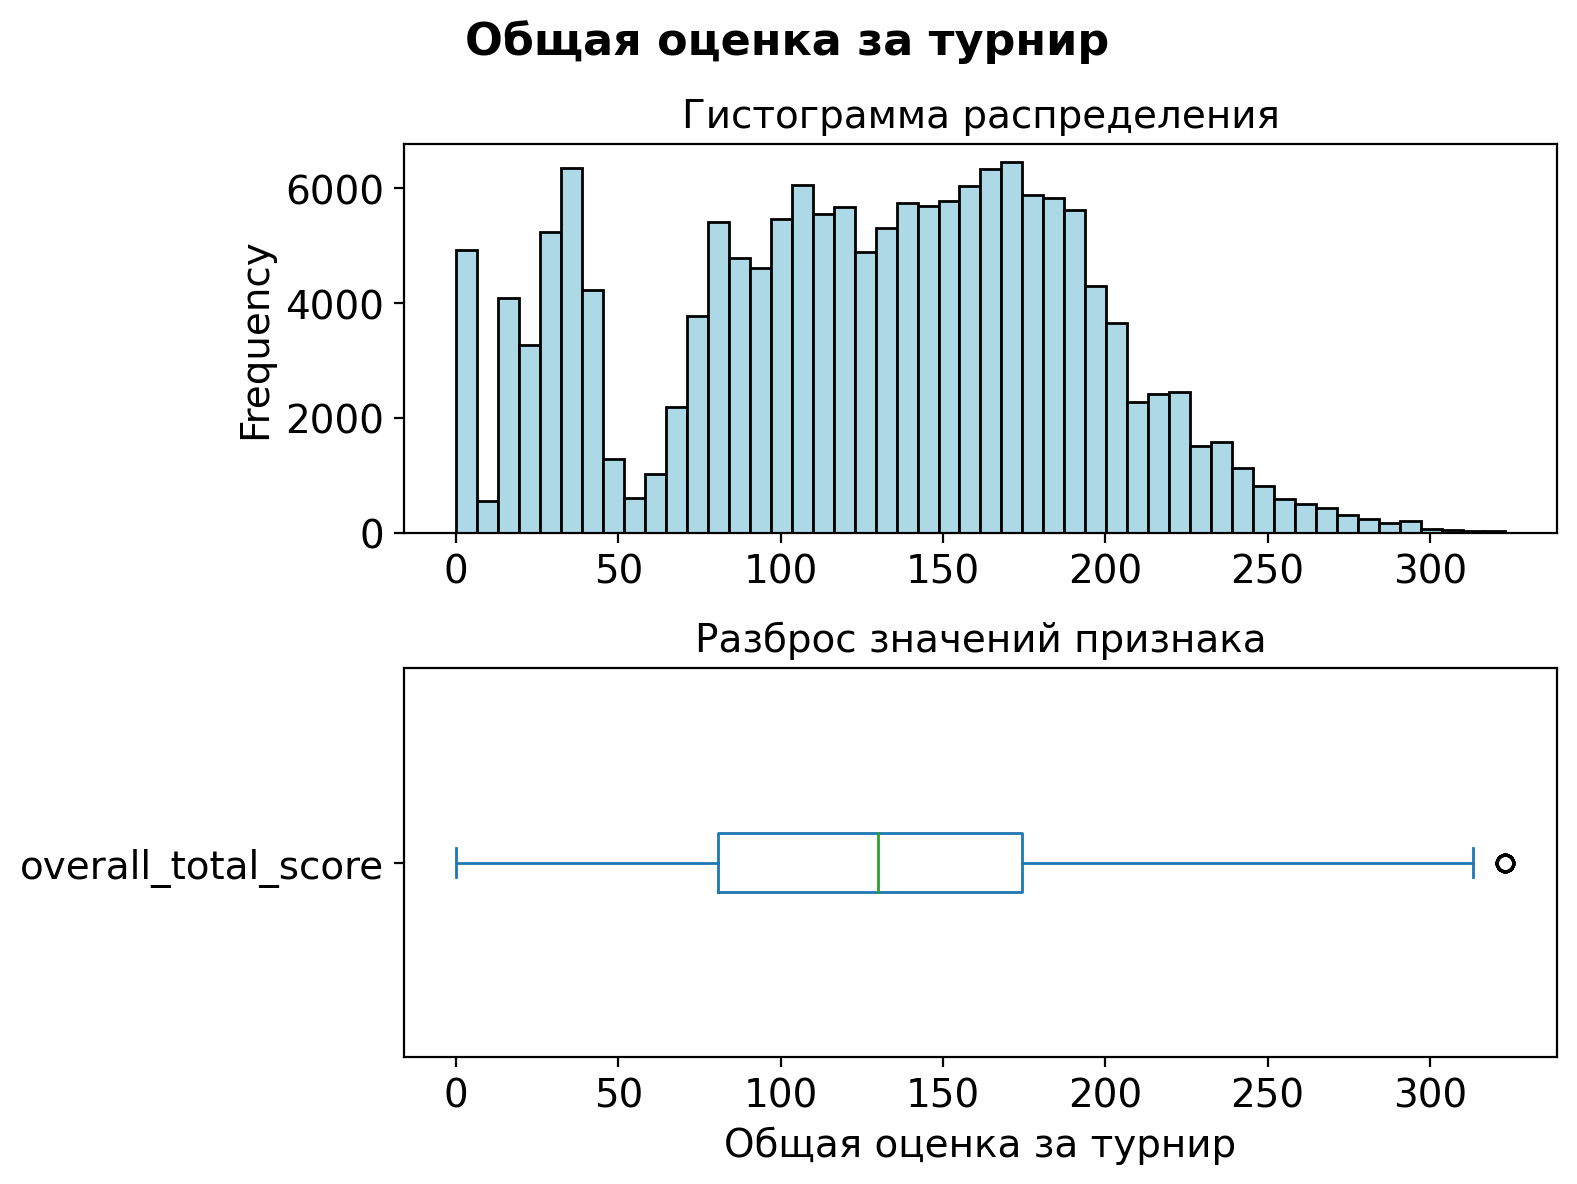

In [130]:
build_hist_num_feature('overall_total_score', 50, 'Общая оценка за турнир')

In [131]:
def build_disc_plot(feature, title):
  """
  функция, которая строит горизонтальную столбчатую диаграмму и
  круговую диаграмму для категориального и дискретного признака.
  входные данные:
    # feature - название столбца с признаком,
    # title - название признака
  """
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
  fig.suptitle('Распределение признака '+title)
  # построение горизонтальной столбчатой диаграммы
  to_model[feature] \
    .value_counts(ascending=True) \
        .to_frame() \
        .plot(y='count', kind='barh',
              legend=False, ax=ax1,
              color='lightblue', ec='black')

  ax1.set_title('Количество')
  ax1.set_ylabel(title)
  ax1.set_xlabel('')

  # добавление меток для каждого столбца
  for index, value in enumerate(to_model[feature].value_counts(ascending=True)):
    ax1.text(value, index, str(value), ha='left', va='center')

  # построение круговой диаграммы
  to_model[feature] \
        .value_counts() \
        .to_frame() \
        .plot(y='count', kind='pie', autopct='%1.1f%%', legend=False, ylabel='',
              cmap='Paired', wedgeprops=dict(width=0.5), ax=ax2)
  ax2.set_title('Доля')

  plt.tight_layout()
  plt.show()

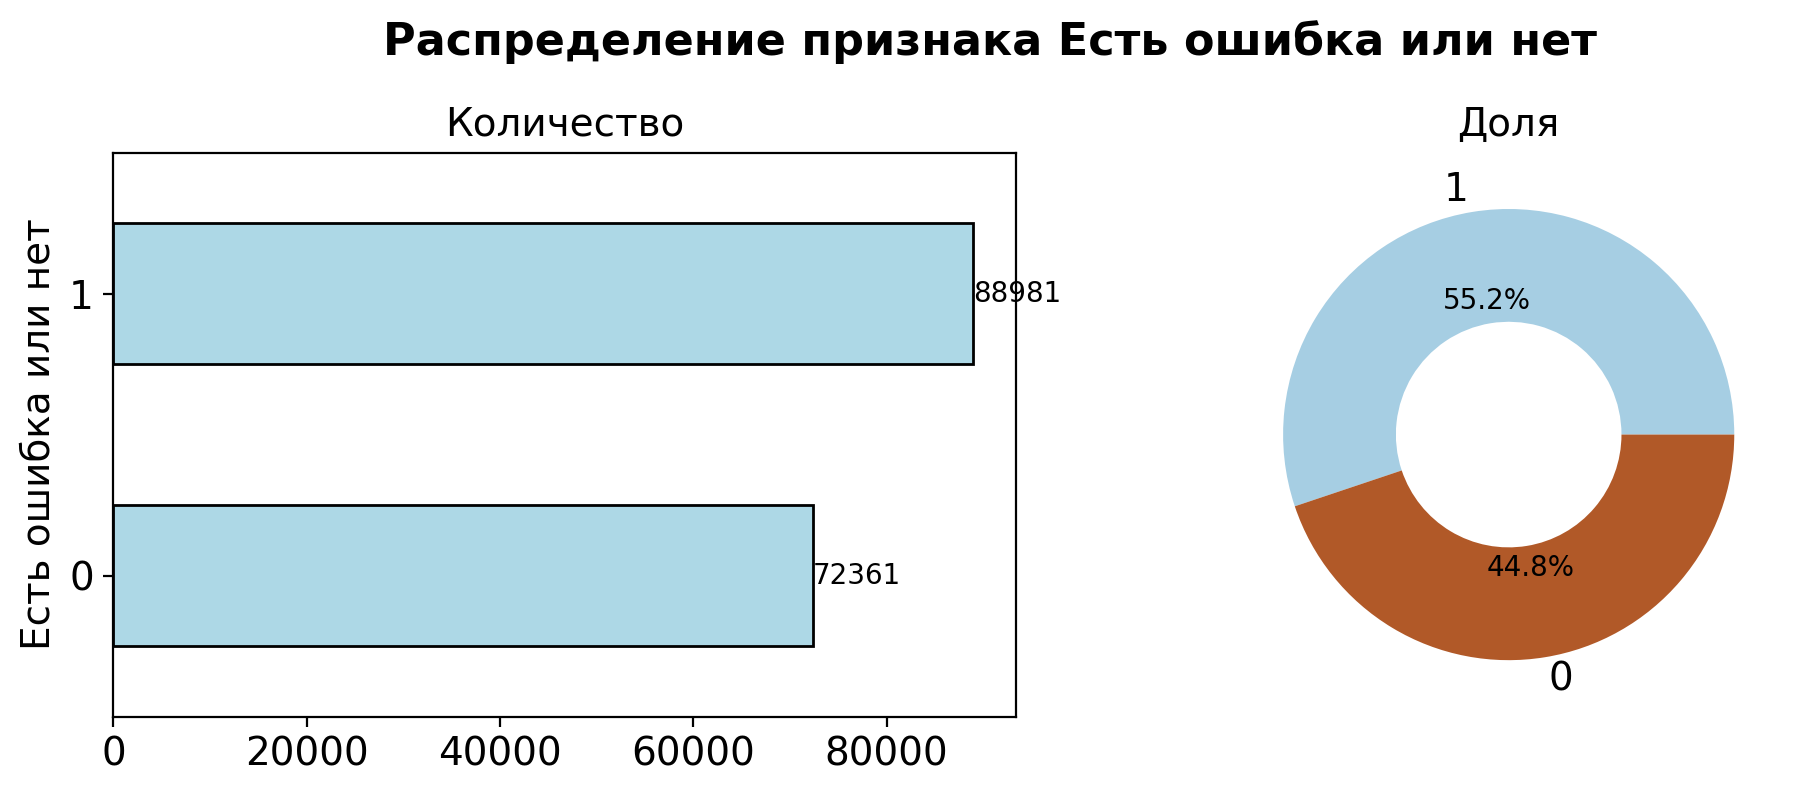

In [132]:
build_disc_plot('error_bin', 'Есть ошибка или нет')

Таким образом, видим, что в целевом признаке обоих классов примерно равное количество, т.е. дисбаланс отсутствует.

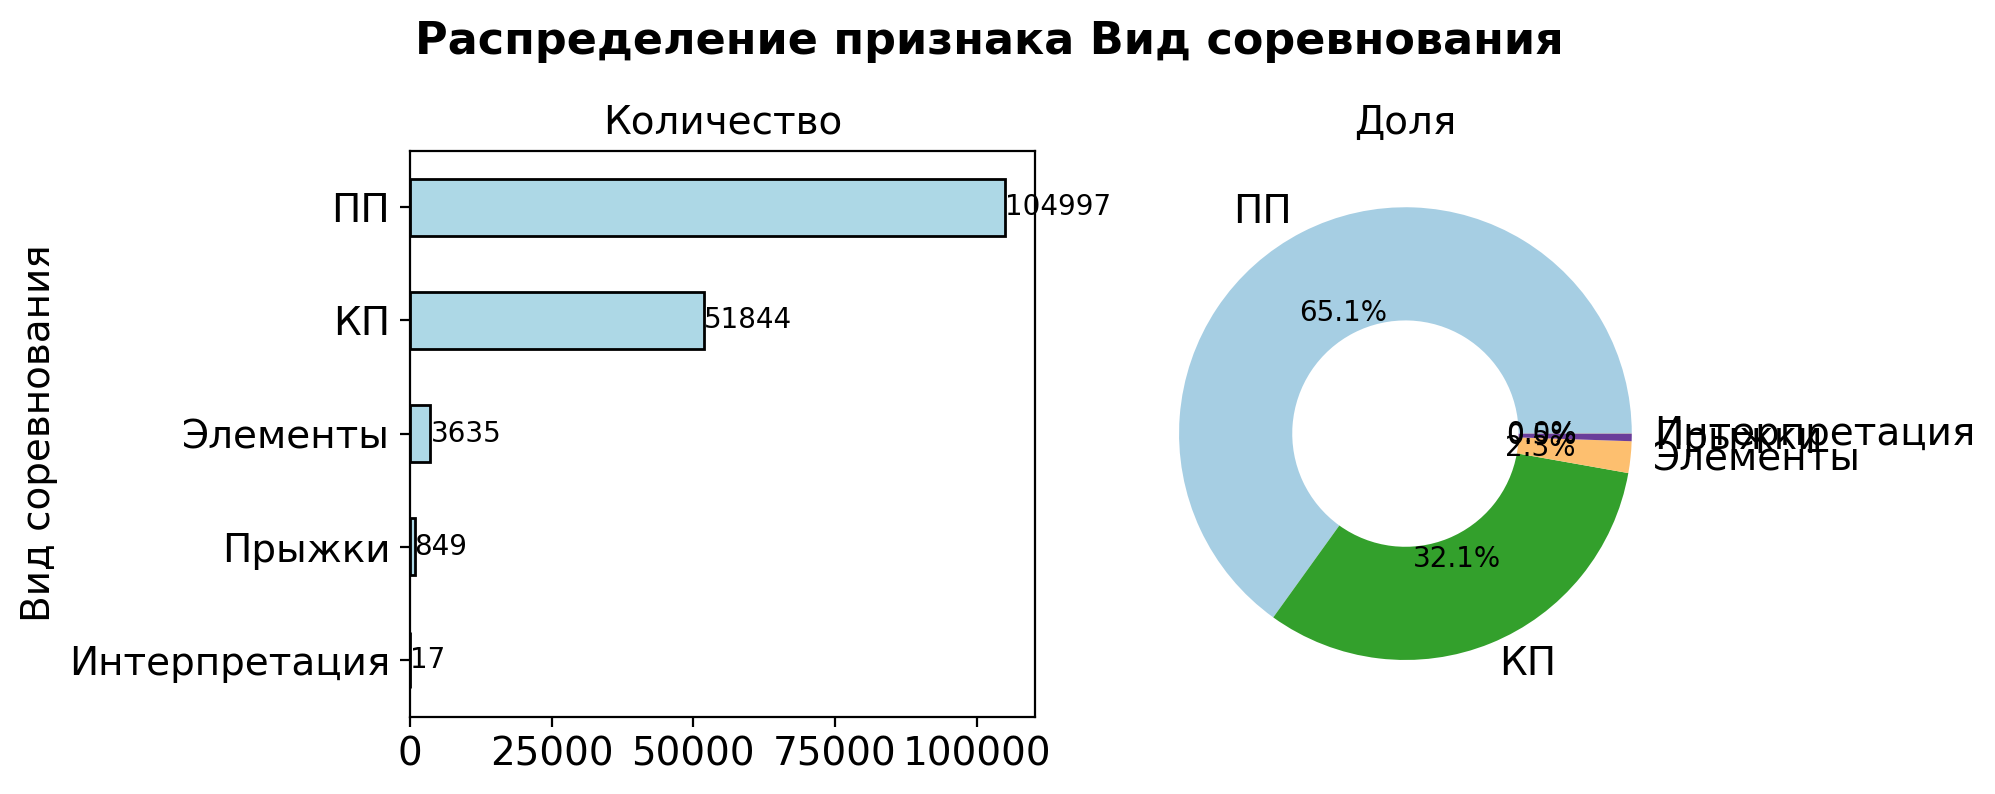

In [133]:
build_disc_plot('segment_name', 'Вид соревнования')

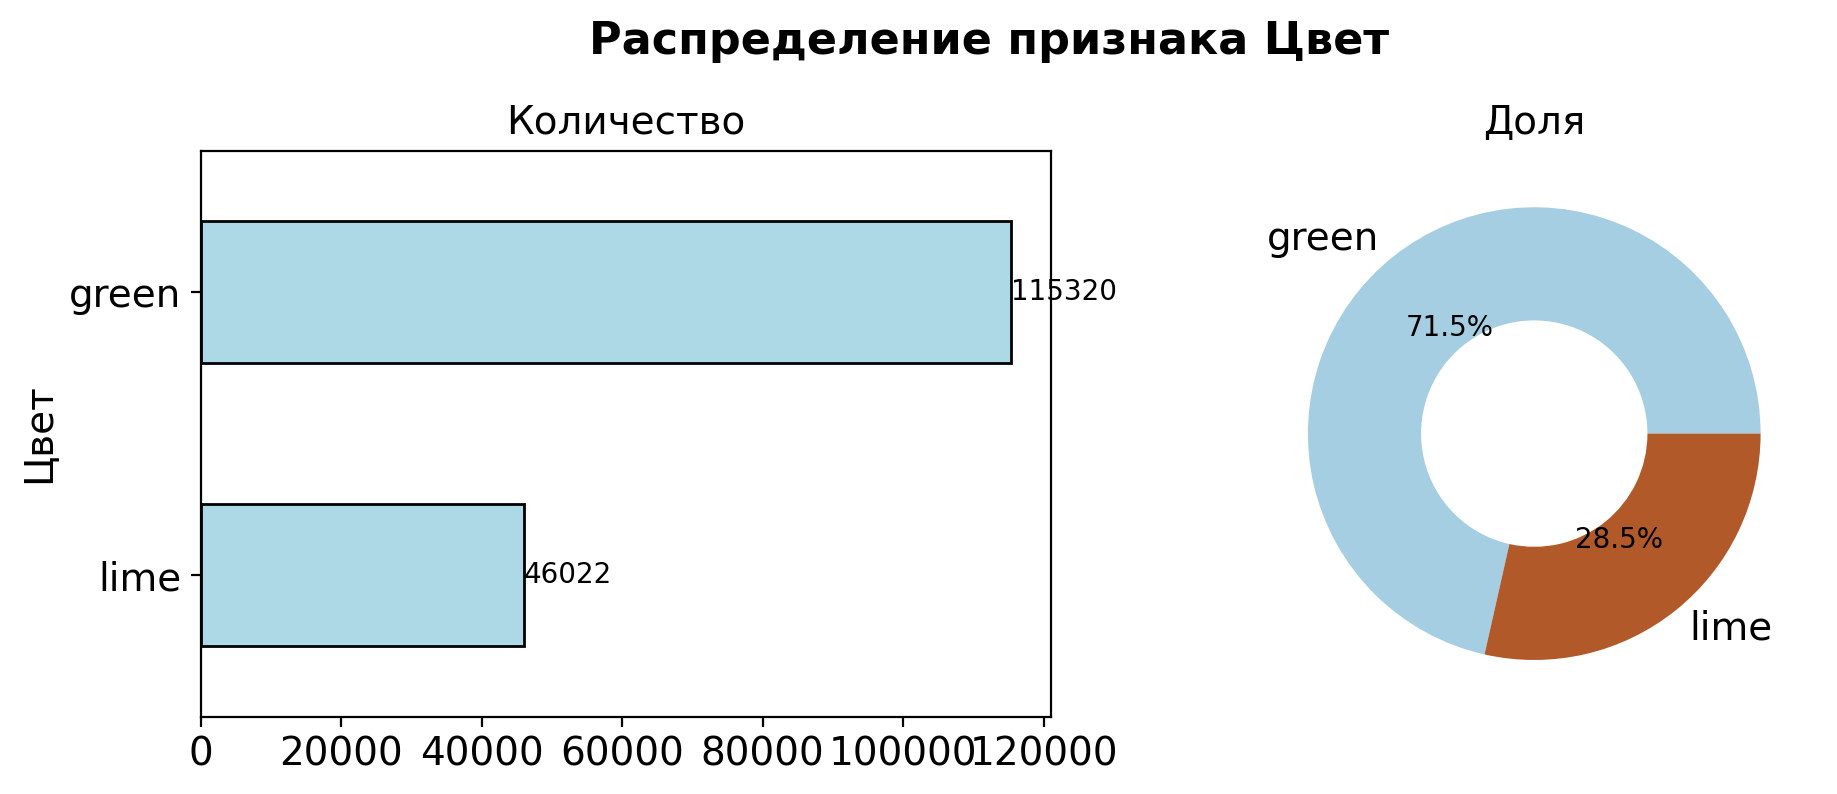

In [134]:
build_disc_plot('color', 'Цвет')

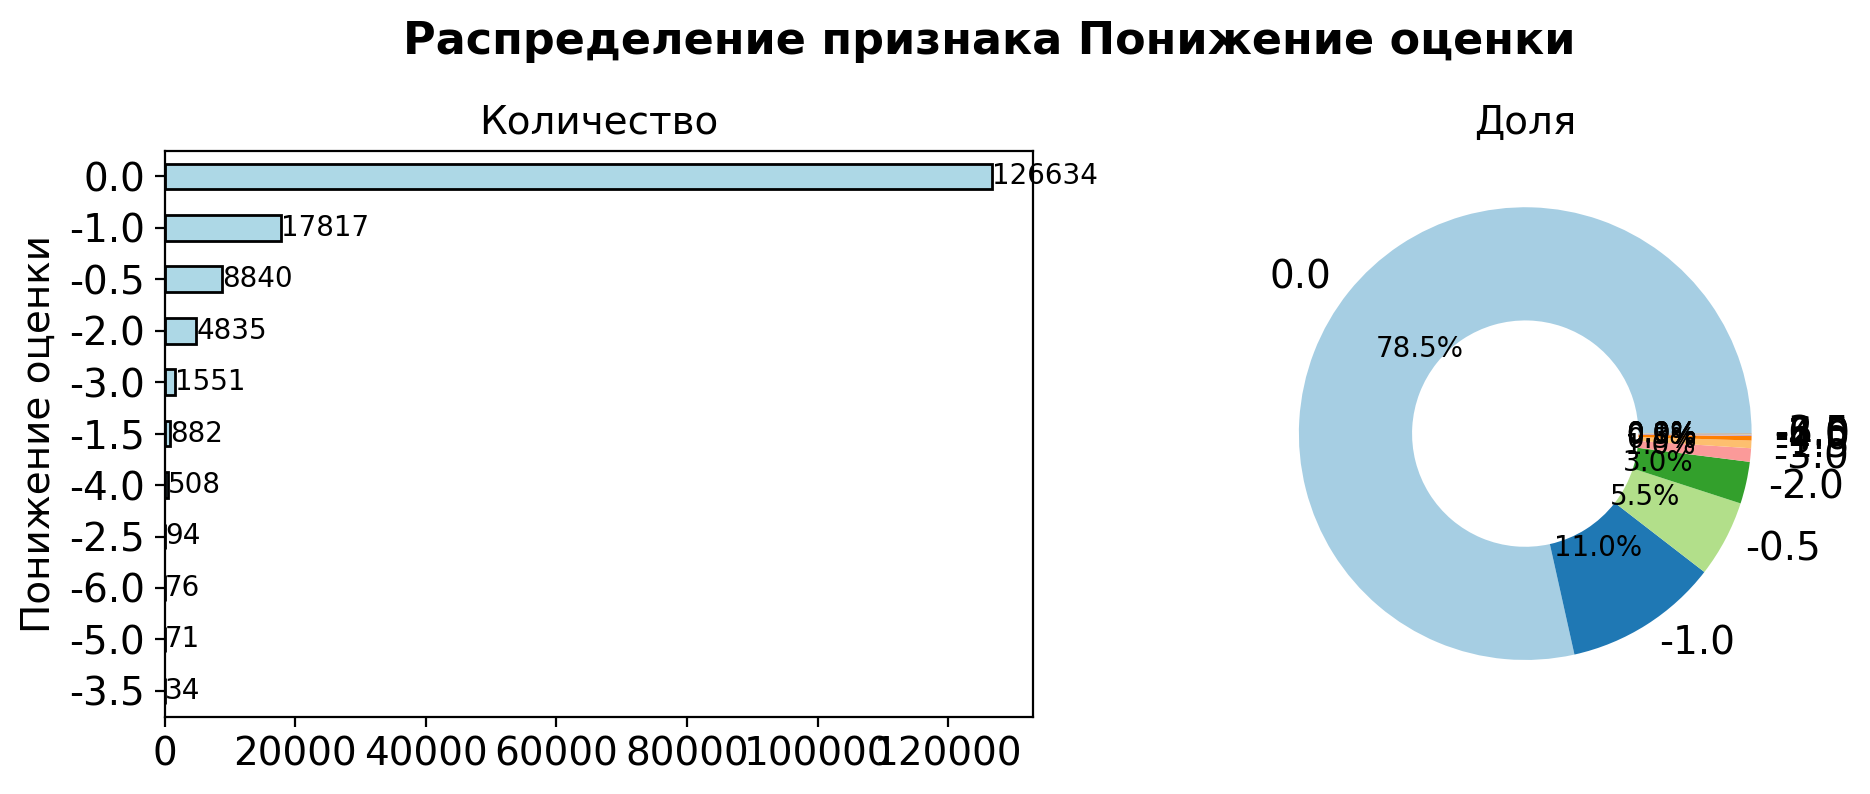

In [135]:
build_disc_plot('decreasings_score', 'Понижение оценки')

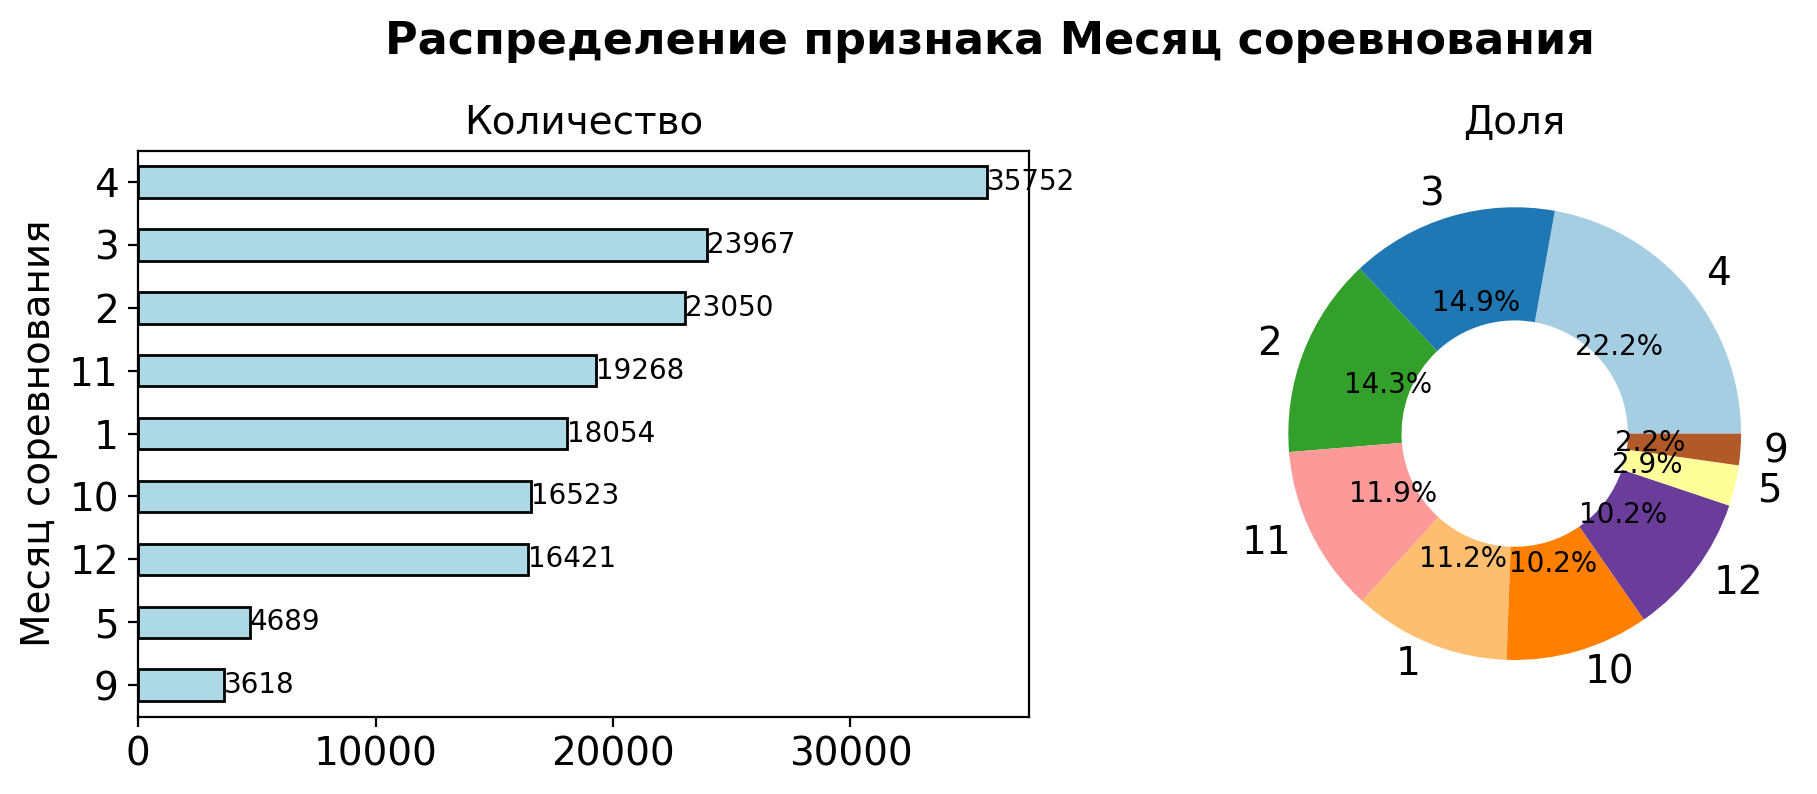

In [136]:
build_disc_plot('month', 'Месяц соревнования')

Большинство соревнований проводится весной (март-апрель) - 59719, что составляет 37% от общего числа. Нет соревнований только в летние месяцы июнь-август.

In [137]:
def give_statistics(unit):
  """
  функция, которая выдаёт статистику по одному спортсмену
  входные данные: unit - id фигуриста
  """
  unit_df = to_model.loc[to_model['unit_id'] == unit]

  print('-'*50)
  print(f"Участвовал в {unit_df['tournament_id'].count()} соревнованиях")
  print(f"Самое высокое место, которое завоевал {unit_df.loc[unit_df['overall_place'] > 0, 'overall_place'].min()}")
  print(f"Максимальное количество баллов за турнир {unit_df['overall_total_score'].max()}")
  print('-'*50)
  bad_jump = unit_df.loc[unit_df['error_bin'] == 1, 'jump'] \
      .value_counts() \
      .reset_index()
  print(f"Больше всего ошибок в прыжке: {bad_jump.loc[0, 'jump']}")

  fig = plt.figure(constrained_layout=True)
  spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
  fig.suptitle('Элементы, выполненные фигуристом')

  # построение графика №1 для прыжков
  ax1 = fig.add_subplot(spec[0, 0])
  unit_df['jump'] \
    .value_counts(ascending=True) \
        .to_frame() \
        .plot(y='count', kind='barh',
              legend=False, ax=ax1, figsize=(8, 8),
              color='lightblue', ec='black')

  ax1.set_title('Количество')
  ax1.set_ylabel('Прыжки')
  ax1.set_xlabel('')

  # добавление меток для каждого столбца
  for index, value in enumerate(unit_df['jump'].value_counts(ascending=True)):
    ax1.text(value, index, str(value), ha='left', va='center')

  # построение графика №2 (круговой диаграммы) для прыжков
  ax2 = fig.add_subplot(spec[0, 1])
  unit_df.loc[unit_df['jump'].notnull(), 'error_bin'] \
        .value_counts() \
        .to_frame() \
        .plot(y='count', kind='pie', autopct='%1.1f%%', legend=False, ylabel='',
              cmap='Paired', wedgeprops=dict(width=0.5), ax=ax2)
  ax2.set_title('Из них\n1 - выполнено с ошибкой, 0 - чисто')

  # построение графика №3 для вращений
  ax3 = fig.add_subplot(spec[1, 0])
  unit_df['spin'] \
    .value_counts(ascending=True) \
        .to_frame() \
        .plot(y='count', kind='barh',
              legend=False, ax=ax3, figsize=(8, 8),
              color='lightblue', ec='black')

  ax3.set_title('Количество')
  ax3.set_ylabel('Вращения')
  ax3.set_xlabel('')

  # добавление меток для каждого столбца
  for index, value in enumerate(unit_df['spin'].value_counts(ascending=True)):
    ax3.text(value, index, str(value), ha='left', va='center')

  # построение графика №4 (круговой диаграммы) для вращений
  ax4 = fig.add_subplot(spec[1, 1])
  unit_df.loc[unit_df['spin'].notnull(), 'error_bin'] \
        .value_counts() \
        .to_frame() \
        .plot(y='count', kind='pie', autopct='%1.1f%%', legend=False, ylabel='',
              cmap='Paired', wedgeprops=dict(width=0.5), ax=ax4)
  ax4.set_title('Из них\n1 - выполнено с ошибкой, 0 - чисто')

  # построение графика №5 для дорожки шагов
  ax5 = fig.add_subplot(spec[2, 0])
  unit_df['step'] \
    .value_counts(ascending=True) \
        .to_frame() \
        .plot(y='count', kind='barh',
              legend=False, ax=ax5, figsize=(8, 8),
              color='lightblue', ec='black')

  ax5.set_title('Количество')
  ax5.set_ylabel('Дорожка шагов')
  ax5.set_xlabel('')

  # добавление меток для каждого столбца
  for index, value in enumerate(unit_df['step'].value_counts(ascending=True)):
    ax5.text(value, index, str(value), ha='left', va='center')

  # построение графика №6 (круговой диаграммы) для дорожки шагов
  ax6 = fig.add_subplot(spec[2, 1])
  unit_df.loc[unit_df['step'].notnull(), 'error_bin'] \
        .value_counts() \
        .to_frame() \
        .plot(y='count', kind='pie', autopct='%1.1f%%', legend=False, ylabel='',
              cmap='Paired', wedgeprops=dict(width=0.5), ax=ax6)
  ax6.set_title('Из них\n1 - выполнено с ошибкой, 0 - чисто')

  plt.tight_layout()
  plt.show()

--------------------------------------------------
Участвовал в 98 соревнованиях
Самое высокое место, которое завоевал 1
Максимальное количество баллов за турнир 103.3
--------------------------------------------------
Больше всего ошибок в прыжке: 2F


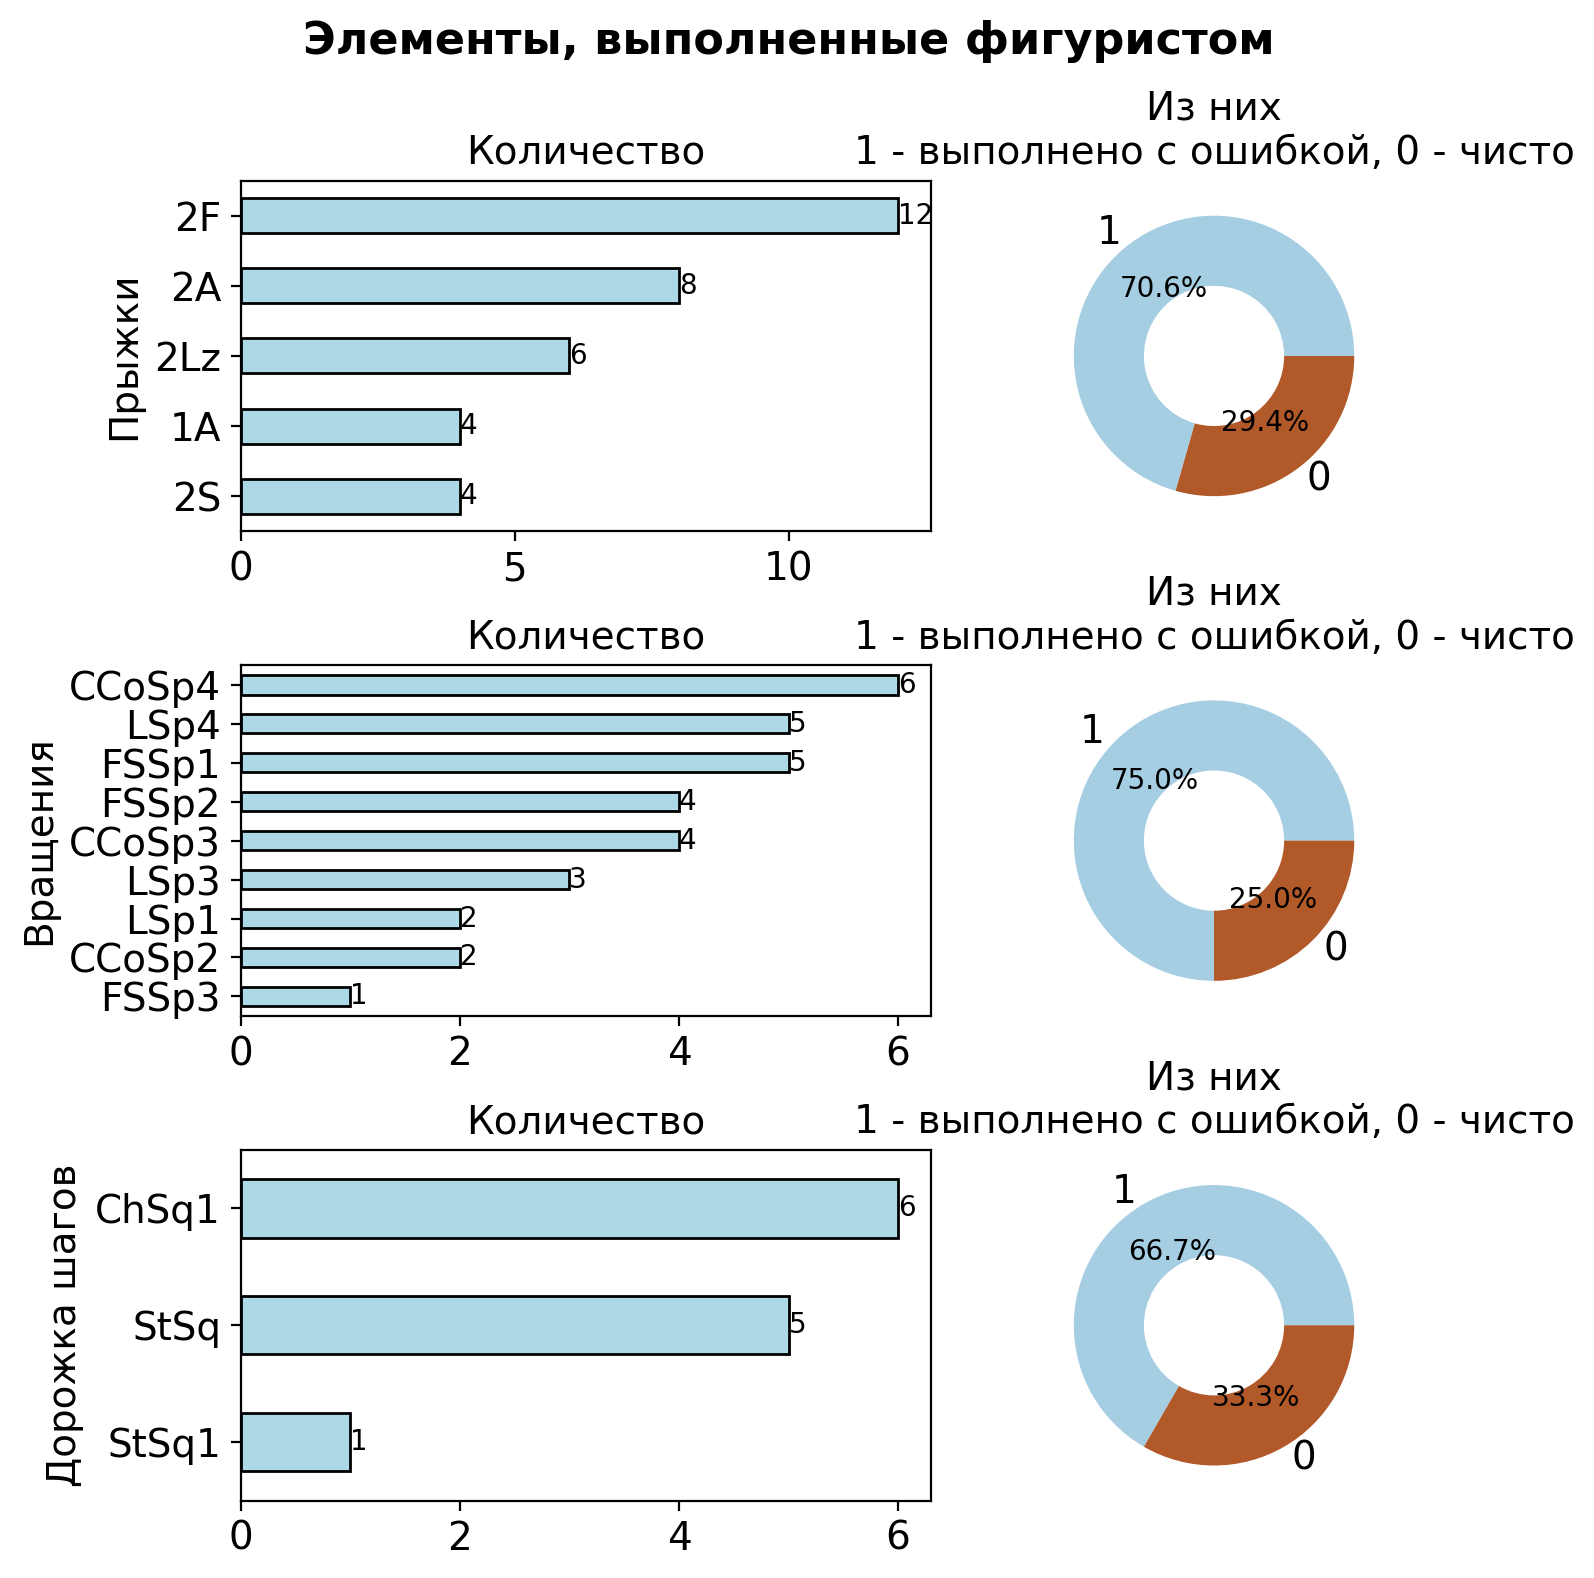

In [138]:
# вызов функции для получения статистики по конкретному unit_id
give_statistics(110)

## Корреляционный анализ

In [139]:
to_model.shape

(161342, 35)

Данные очень объёмные. Вычислительных мощностей не хватает их просчитать, поэтому возьмем подвыборку из первых 90000 строк.

In [140]:
# создание подвыборки из первых 90000 строк
part_1 = to_model.iloc[:90000]

Построим попарные графики для разных видов оценок с раскраской точек по типу сегмента (Короткая/произвольная программа, Элементы, Интерпретация)

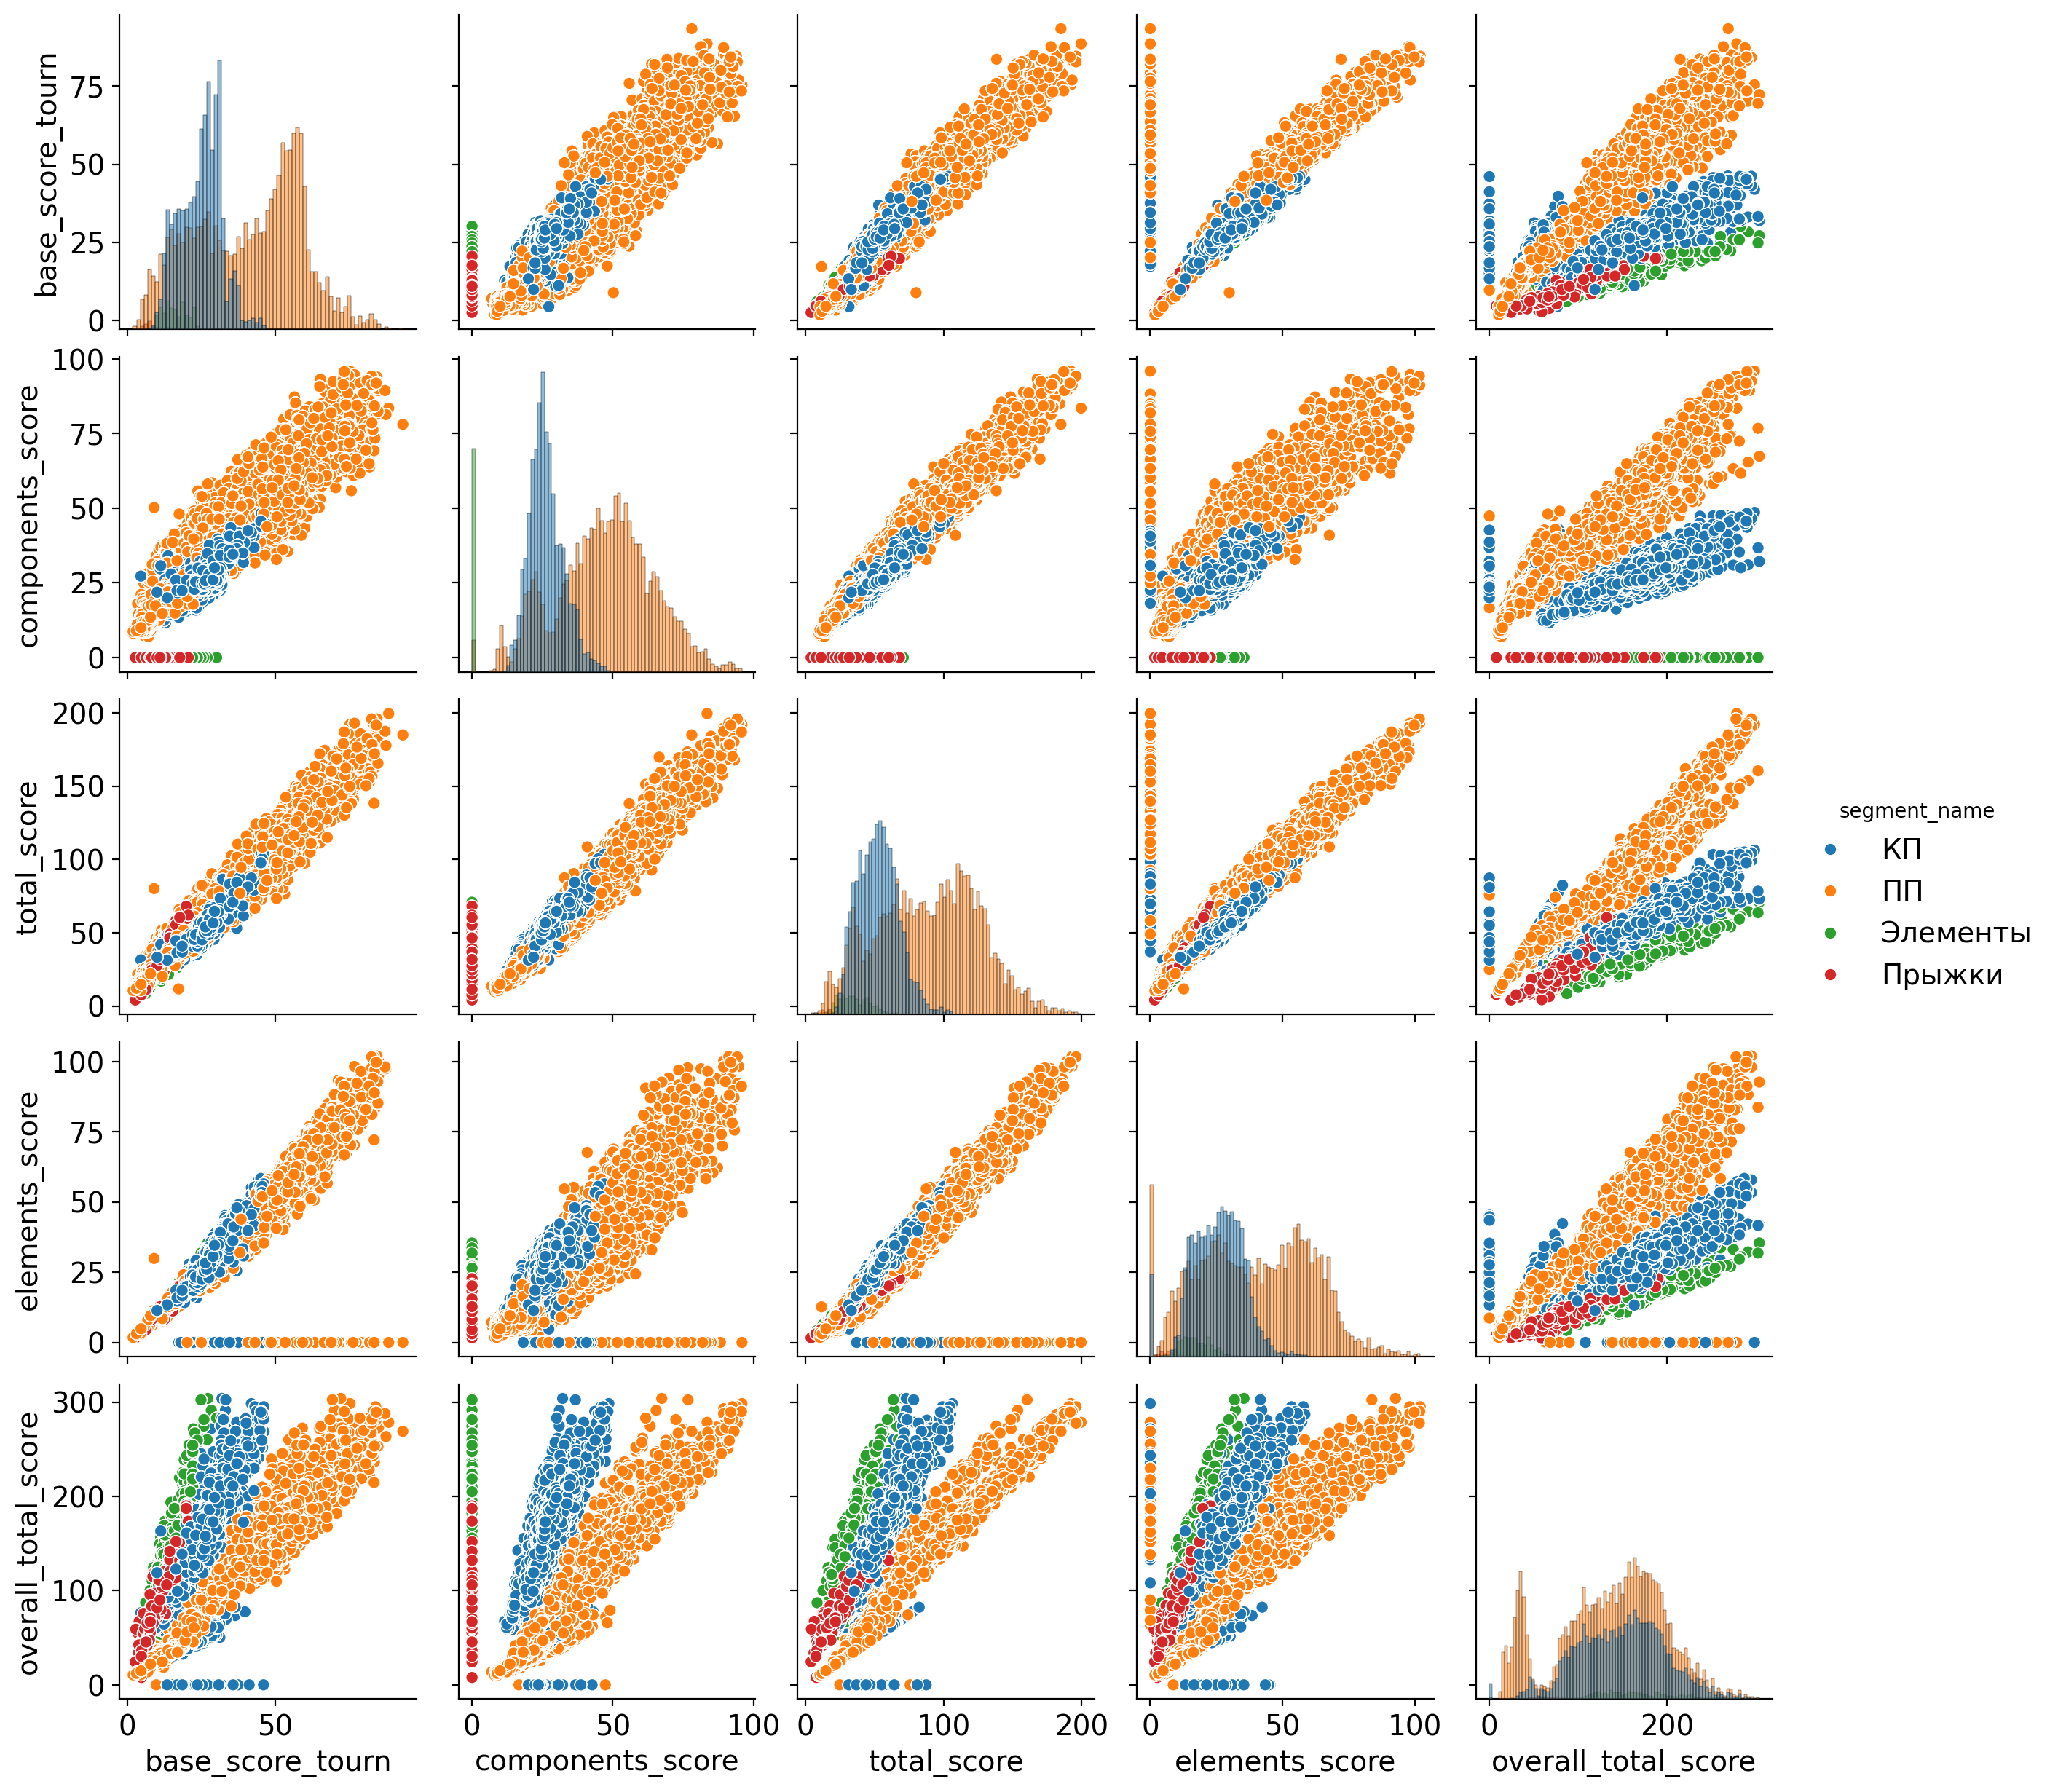

In [141]:
# построение попарного графика для оценок
sns.pairplot(
    part_1[['base_score_tourn', 'components_score', 'total_score',
              'elements_score', 'overall_total_score', 'segment_name']],
    hue='segment_name', diag_kind='hist')

По полученным графикам видно, что значения, соответствующие разным сегментам (Короткая программа, произвольная программа, элементы, прыжки), группируются в отдельные облака точек. Соответственно у признака `segment_name` можно ожидать хорошую корреляционную связь с признаками, показывающими распределение оценок.
Также выделяются нулевые значения оценок, выбивающиеся из имеющейся прямой линейной связи.

Рассчитаем коэффициенты корреляции между признаками разных типов данных. Для этого используем библиотеку phik.

In [142]:
# удалим признаки, которые в рамках данной задачи не пригодятся
part_1 = part_1.drop(['jump', 'step', 'spin', 'cascade',
                          'error_from_title', 'error_from_info',
                          'errors', 'date_start', 'date_end',
                          'info', 'title'], axis=1)

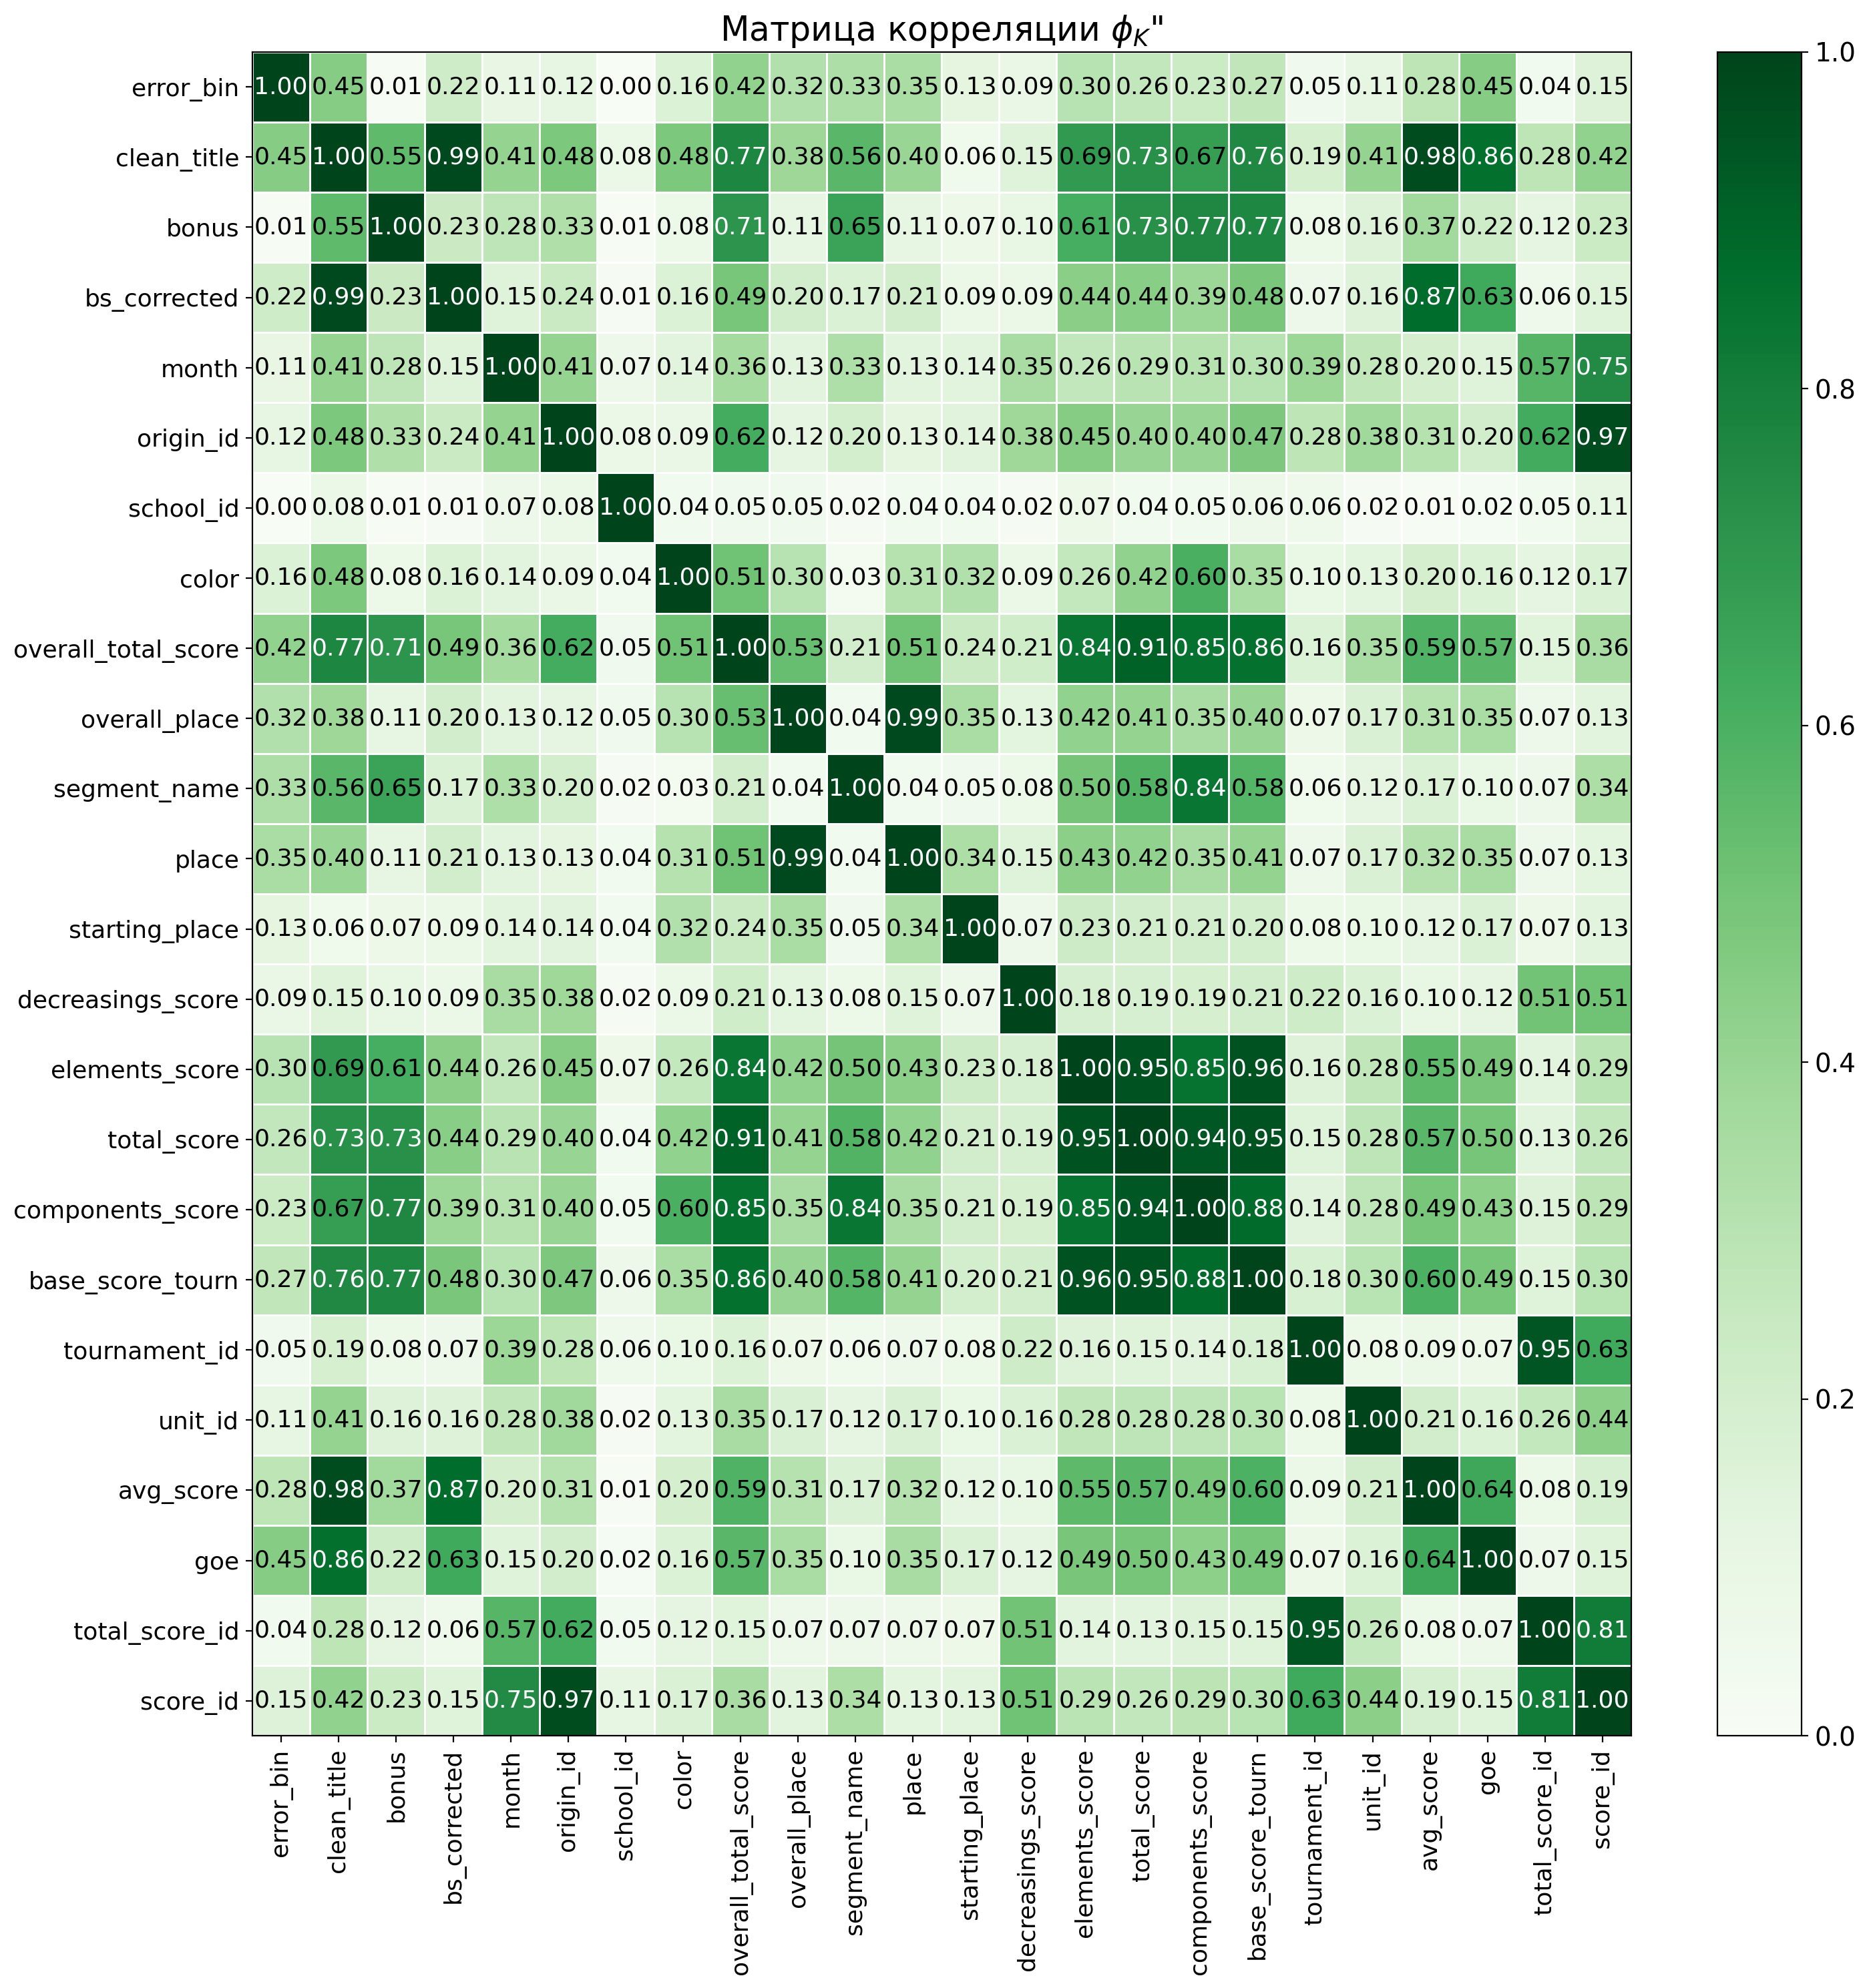

In [143]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['score_id',
                 'total_score_id',
                 'goe',
                 'avg_score',
                 'unit_id',
                 'tournament_id',
                 'base_score_tourn',
                 'components_score',
                 'total_score',
                 'elements_score',
                 'starting_place',
                 'place',
                 'overall_place',
                 'overall_total_score',
                 'school_id',
                 'bs_corrected']

# считаем коэффициенты корреляции
phik_overview= phik_matrix(part_1, interval_cols=interval_cols)

# строим матрицу корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции $\phi_K$"',
    fontsize_factor=1.3,
    figsize=(15, 15)
)
plt.show()

Признак `school_id` можно удалить, т.к. у него очень слабая связь со всеми признаками и, следовательно, ценность его невысока.
У признаков `place` и `overall_place` наблюдается очень сильная связь равная 98%. Это плохо скажется на линейных моделях, поэтому признак `place` можно удалить. Также признаки `bs_corrected` и `clean_title` имеют тесную взаимосвязь. Удалим `bs_corrected`.

## Обучение модели

In [144]:
part_1 = part_1.drop(['place', 'bs_corrected'], axis=1)

In [145]:
# разделим данные на числовые (float и int) и строковые (object)
num_columns = part_1.select_dtypes('number').columns.tolist()
cat_columns= part_1.select_dtypes('object').columns.tolist()

In [146]:
num_columns = ['score_id',
               'total_score_id',
               'goe',
               'avg_score',
               'unit_id',
               'tournament_id',
               'base_score_tourn',
               'components_score',
               'total_score',
               'elements_score',
               'decreasings_score',
               'starting_place',
               'overall_place',
               'overall_total_score',
               'school_id',
               'origin_id',
               'month']

In [147]:
# записываем входные данные в переменную Х, целевой признак в переменную у
X = part_1.drop(['error_bin'], axis=1)
y = part_1['error_bin']

# делим выборку на тренировочную и тестовую со статификацией по целевому признаку
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    shuffle = False)

print(f"Размер обучающей выборки: {X_train.shape}, тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (63000, 21), тестовой выборки: (27000, 21)


In [148]:
# создание пустого списка для добавления лучших метрик по всем лучшим моделям
rocauc_cv = []

# создание объекта-генератора разбиений для временного ряда с числом фолдов равным 5
tscv = TimeSeriesSplit(n_splits=5)

def prep_model_pipe(model, params):
    '''
    Функция, которая подготавливает признаки, производит подбор гиперпараметров и
    возвращает лучшую модель
    '''
    # соберём пайплайн подготовки данных
    # SimpleImputer + OHE
    ohe_pipe = Pipeline([
        (
            'simple_imputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        ('ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ])

    data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

    # финальный пайплайн
    pipeline = Pipeline([
        ('preprocessor', data_preprocessor),
        ('clf', model),
    ])

    rs = RandomizedSearchCV(
        pipeline,
        params,
        cv=tscv,
        scoring='roc_auc',
        random_state=RANDOM_STATE,
        n_jobs=14
        )

    # запуск поискa  лучших гиперпараметров
    rs.fit(X_train, y_train)

    print('Параметры лучшей модели:\n\n', rs.best_estimator_)
    print(f'Среднее значение ROC-AUC на кросс-валидации лучшей модели: {round(rs.best_score_, 3)}')

    rocauc_cv.append(rs.best_score_)

    return rs.best_estimator_

### Модель LogisticRegression

In [149]:
# словарь с параметрами для LogisticRegression
lr_params = {'clf__C': range(1, 15, 3)
            }

# инициализируем модель LogisticRegression
model_lr = LogisticRegression(random_state=RANDOM_STATE,
                              solver='liblinear',
                              max_iter=200)

# вызов функции с расчетом матрицы признаков и подбором гиперпараметров для LogisticRegression
model_lr = prep_model_pipe(model_lr, lr_params)

Параметры лучшей модели:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['segment_name', 'color',
                                                   'bonus', 'clean_title']),
                                                 ('num', StandardScaler(),
                

### Модель RandomForestClassifier()

In [150]:
# передадим словарь с параметрами для RandomForestClassifier
params_rfc = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [10, 20]
}

# инициализируем модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=RANDOM_STATE)

# вызов функции с подготовкой признаков и подбором гиперпараметров для RandomForest
model_rfc = prep_model_pipe(rfc, params_rfc)

Параметры лучшей модели:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['segment_name', 'color',
                                                   'bonus', 'clean_title']),
                                                 ('num', StandardScaler(),
                

### Модель CatBoostClassifier

In [151]:
# словарь с параметрами для CatBoostClassifier()
cbc_params = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [4, 8]
    }

# инициализируем модель CatBoostClassifier()
model_cbc = CatBoostClassifier(custom_metric=['AUC'],
                               eval_metric='AUC',
                               verbose=False)

# подбор гиперпараметров для CatBoostClassifier()
gs = model_cbc.grid_search(cbc_params,
                           Pool(X_train, y_train, cat_features=cat_columns),
                           cv=3,
                           verbose=100)

print('Параметры лучшей модели:\n\n', gs['params'])

rocauc_cv.append(np.mean(gs['cv_results']['test-AUC-mean']))


bestTest = 0.8510832771
bestIteration = 999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8510833	best: 0.8510833 (0)	total: 58.8s	remaining: 2m 56s

bestTest = 0.9555762017
bestIteration = 999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9154291546
bestIteration = 999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric 

In [152]:

model_cat = CatBoostClassifier(depth=gs['params']['depth'],
                               learning_rate=gs['params']['learning_rate'],

                               custom_metric=['AUC:hints=skip_train~false'],
                               verbose=100)
model_cat.fit(Pool(X_train, y_train, cat_features=cat_columns))

0:	learn: 0.6593619	total: 191ms	remaining: 3m 10s
100:	learn: 0.3691438	total: 11.5s	remaining: 1m 42s
200:	learn: 0.2715714	total: 23s	remaining: 1m 31s
300:	learn: 0.2089148	total: 34.9s	remaining: 1m 20s
400:	learn: 0.1677980	total: 46.7s	remaining: 1m 9s
500:	learn: 0.1390385	total: 56.3s	remaining: 56.1s
600:	learn: 0.1169232	total: 1m 7s	remaining: 45s
700:	learn: 0.1013539	total: 1m 19s	remaining: 33.8s
800:	learn: 0.0877599	total: 1m 30s	remaining: 22.6s
900:	learn: 0.0765867	total: 1m 42s	remaining: 11.2s
999:	learn: 0.0677160	total: 1m 52s	remaining: 0us


## Тестирование

Соберем все метрики ROC-AUC, оцененные на кросс-валидации по всем моделям в датафрейм.

In [153]:
result = pd.DataFrame(
    {
    "Модель": ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier'],
    "ROC-AUC на cv": rocauc_cv
    }
)

result

Модель  ROC-AUC на cv
0      LogisticRegression       0.802755
1  RandomForestClassifier       0.792347
2      CatBoostClassifier       0.970768

По результатам кросс-валидации лучшей оказалась модель CatBoostClassifier с параметрами {'depth': 8, 'learning_rate': 0.1}. Ее метрика ROC-AUC равна 97%. Сделаем по ней прогнозы на тестовой выборке, чтобы оценить финальную метрику и чтобы проверить переобученность модели.

In [154]:
# рассчитаем прогноз и метрики на тестовых данных
y_test_pred = model_cat.predict(X_test)
y_pred = model_cat.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_test, 3)}')

Метрика ROC-AUC на тестовой выборке: 0.846


Метрика ROC-AUC на тестовых данных оказалась равной 84.6%.

Оценим также качество на константной Dummy модели.

In [155]:
# создание и обучение модели DummyClassifier
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict_proba(X_test)[:, 1]

# оценка качества dummy модели по метрике ROC-AUC
rocauc_dummy = roc_auc_score(y_test, dummy_model_preds)
print(f'Метрика ROC-AUC на тестовой выборке дамми-модели: {round(rocauc_dummy, 3)}')

Метрика ROC-AUC на тестовой выборке дамми-модели: 0.5


Метрика ROC-AUC на дамми модели оказалась существенно хуже всех обученных моделей.

### Анализ важности

Анализ важности признаков сделаем методом SHAP, который позволяет определить как каждый отдельный признак повлиял на классификацию результата.

In [156]:
# расчет SHAP значений для модели CatBoostClassifier
explainer = shap.TreeExplainer(model_cat)
shap_values = explainer(X_test)

Посмотрим на столбчатую диаграмму 'shap.plots.bar', которая показывает средние SHAP-значения по всем наблюдениям.

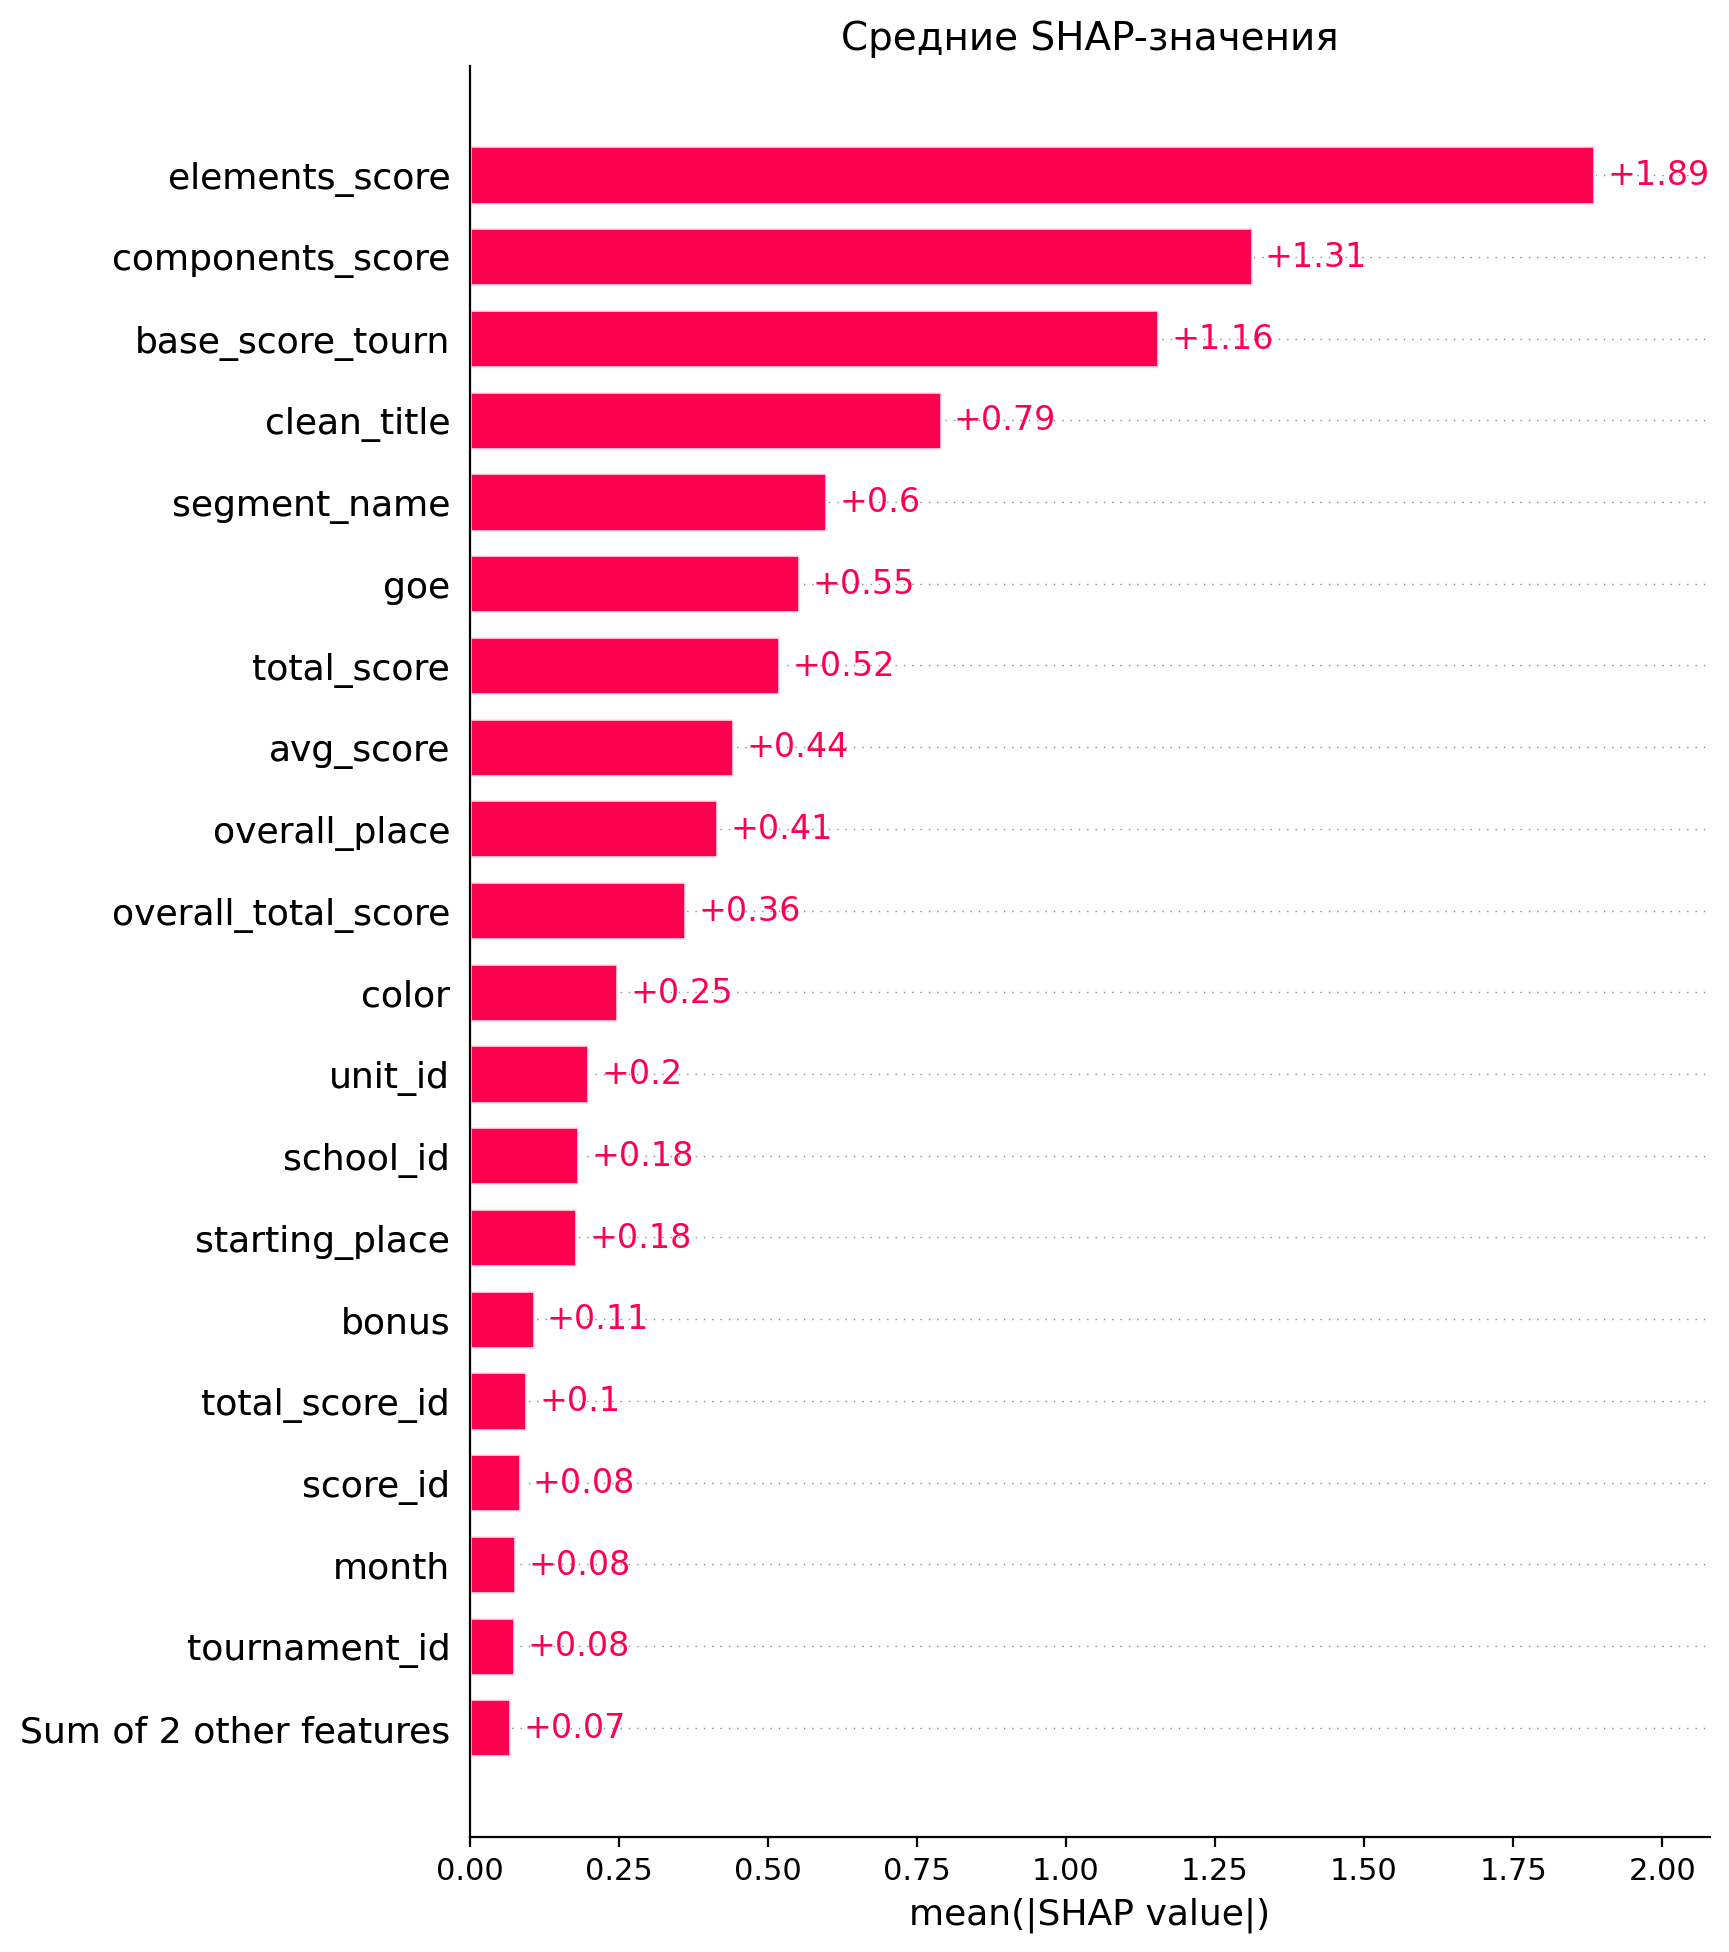

In [157]:
# построение столбчатой диаграммы средних SHAP-значений
plt.title('Средние SHAP-значения')
shap.plots.bar(shap_values, max_display=20)

Из полученной диаграммы следует, что самый большой вес у признака `elements_score`, он сильнее всего влияет на прогнозы модели. Далее в топ-5 наиболее влияющих признаков по убыванию значимости:
- `components_score`,
- `base_score_tourn`,
- `clean_title`,
- `segment_name`.

В целом получается достаточно объяснимая ситуация: чем меньше ошибок совершает фигурист, тем меньше очков у него вычитают, тем больший итоговый `overall_total_score` и лучшее `overall_place`. На разных турнирах (разные `tournament_id`) принимают участие спортсмены разного уровня, поэтому количество ошибок на турнирах различается. Также следующий по значимости признак `unit_id` является важным, т.к. разные спорстмены совершают разное количество ошибок, причем в зависимости от типа элемента, за что отвечает признак `clean_title`.

А теперь посмотрим как именно изменение одного признака влияет на итоговый прогноз.

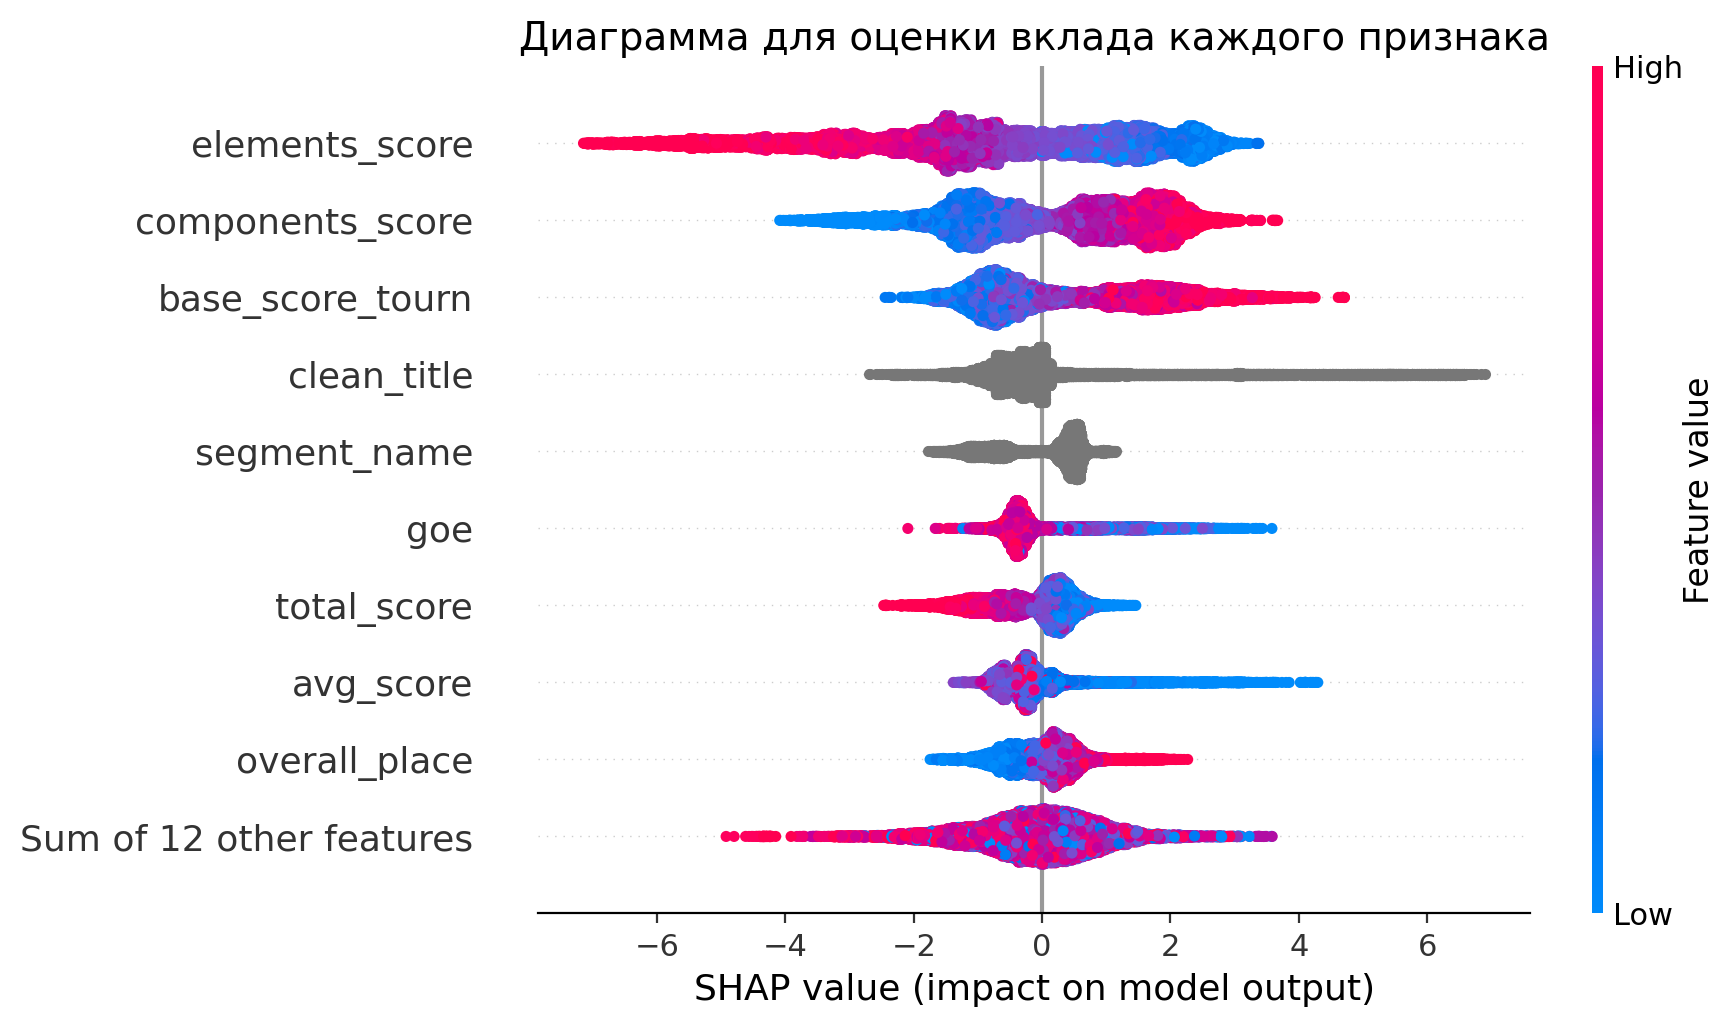

In [158]:
# построение диаграммы beeswarm
plt.title('Диаграмма для оценки вклада каждого признака')
shap.plots.beeswarm(shap_values)

Увеличение признака `elements_score` склоняет прогноз в сторону класса "0". Достаточно неожиданным оказалось, что увеличение признака `component_score` склоняет к прогнозу класса "1", т.е. наличию ошибки. Возможно, после явной технической ошибки спортсмен по полной выкладывается на хореографии за что и получает высокие баллы за артистизм.

### Матрица ошибок

Построим матрицу ошибок, чтобы понимать ошибки какого рода модель чаще совершает.

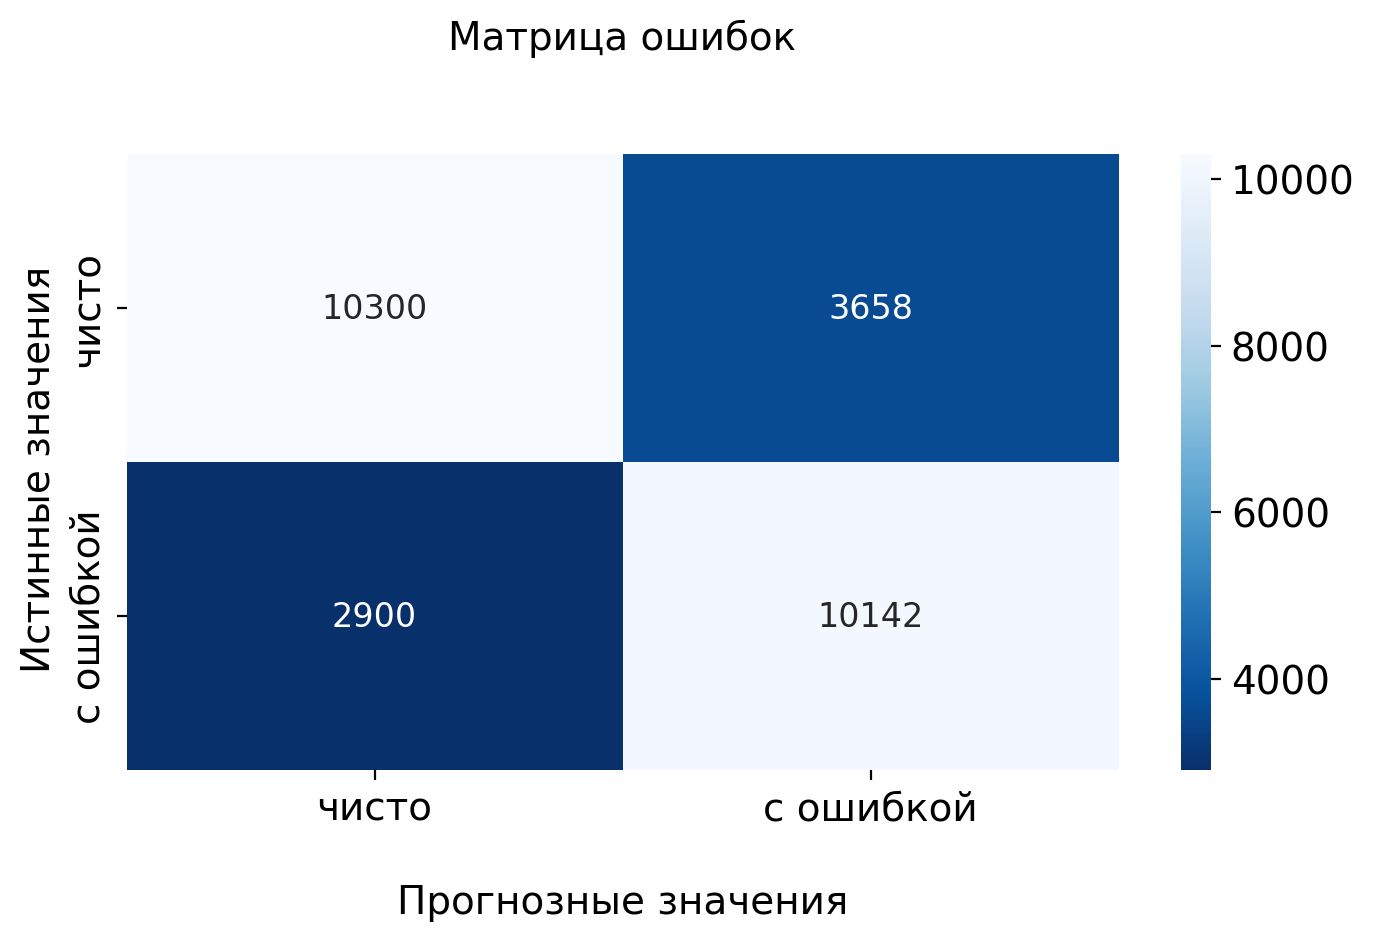

In [159]:
# расчет матрицы ошибок
cm = confusion_matrix(y_test, y_test_pred)

# визуализация матрицы ошибок с помощью тепловой карты
fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.heatmap(cm, annot=True, cmap='Blues_r', annot_kws={"size":12}, fmt=".0f")

ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПрогнозные значения')
ax.set_ylabel('Истинные значения ')

ax.xaxis.set_ticklabels(['чисто', 'с ошибкой'])
ax.yaxis.set_ticklabels(['чисто', 'с ошибкой'])

plt.show()

Матрица ошибок показала хороший результат: верно были предсказаны 20442 (TP+TN), а неверно 6558 (FP+FN). Для 2900 случаев модель выдала ложноотрицательный результат, а для 3658 - ложноположительный. Таким образом, существует больший риск ошибочно предсказать ошибку, нежели чистое выступление.

## Общий вывод:

В ходе данного проекта были изучены данные по 142 турнирам и 3393 спортсмену.

На этапе <u>обучения модели</u> было построено 3 модели: LogisticRegression, CatBoostClassifier, RandomForestClassifier.
По результатам кросс-валидации лучшей оказалась модель CatBoostClassifier с параметрами {'depth': 8, 'learning_rate': 0.1}. Ее метрика ROC-AUC на кросс-валидации равна 97%. Метрика ROC-AUC на тестовых данных равна 84.6%

Дальнейшие шаги:
- доработать этот проект
- разработать систему рекомендаций элементов, которые помогут лучше спланировать программу выступления.